# Análisis Exploratorio de Datos: Ultrasonidos de Plantas

Este notebook realiza un análisis exploratorio completo del dataset de ultrasonidos de plantas y prepara un dataset balanceado.

## Estructura del Dataset:
- **PUA.01** y **PUA.02**: Dos batches de recogida de datos
- **audiofiles**: 15 subdirectorios (PUA???) con sesiones de grabación
- **4 canales**: ch1, ch2, ch3, ch4 (4 micrófonos simultáneos)
- **Ultrasonidos de planta (label=1)**: archivos .wav con correspondiente .png (espectrograma)
- **Sonidos ambientales (label=0)**: archivos .wav SIN correspondiente .png
- **images**: Fotos de las plantas (no utilizadas en este experimento)

## Objetivos:
1. Explorar la estructura del dataset PUA.01 y PUA.02
2. Identificar archivos .wav con/sin espectrogramas .png
3. Crear dataset balanceado (igual número de ultrasonidos vs ambientales)
4. Analizar distribución temporal y por canales de audio
5. Generar CSV final para entrenamiento de modelos de audio

In [1]:
# Importar librerías necesarias
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import cv2
from pathlib import Path
import random
from datetime import datetime
import warnings
import re
from collections import defaultdict
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print("📚 Librerías cargadas correctamente")
print(f"📂 Directorio de datos: ../data")

📚 Librerías cargadas correctamente
📂 Directorio de datos: ../data


## 1. Exploración de la Estructura del Dataset PUA.01 y PUA.02

In [15]:
from tqdm import tqdm

# Explorar estructura del dataset
data_path = Path("../data")


def explore_dataset_structure():
    """Explorar la estructura de directorios del dataset con barra de progreso"""
    structure = {}
    
    print("🔍 Explorando estructura del dataset...")
    
    # Buscar directorios PUA.01 y PUA.02
    pua_dirs = [d for d in data_path.glob("PUA.*") if d.is_dir()]
    for pua_dir in tqdm(pua_dirs, desc="Procesando batches"):
        pua_name = pua_dir.name
        structure[pua_name] = {}
        
        print(f"\n📁 Encontrado: {pua_name}")
        
        # Buscar subdirectorios
        audiofiles_dir = pua_dir / "audiofiles"
        
        if audiofiles_dir.exists():
            # Contar sesiones de audio
            audio_sessions = [d for d in audiofiles_dir.iterdir() if d.is_dir() and d.name.startswith('PUA')]
            structure[pua_name]['audio_sessions'] = len(audio_sessions)
            structure[pua_name]['audio_sessions_list'] = [d.name for d in audio_sessions]
            print(f"   🎙️ Sesiones de audio: {len(audio_sessions)}")
            
            # Contar archivos .wav y .png por canal (progreso por sesión)
            wav_counts = {'ch1': 0, 'ch2': 0, 'ch3': 0, 'ch4': 0, 'total': 0}
            png_counts = {'ch1': 0, 'ch2': 0, 'ch3': 0, 'ch4': 0, 'total': 0}
            for session_dir in tqdm(audio_sessions, desc=f"  Sesiones {pua_name}", leave=False):
                wav_files = list(session_dir.glob("*.wav"))
                png_files = list(session_dir.glob("*.png"))
                wav_counts['total'] += len(wav_files)
                png_counts['total'] += len(png_files)
                for wav_file in wav_files:
                    for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
                        if channel in wav_file.name:
                            wav_counts[channel] += 1
                for png_file in png_files:
                    for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
                        if channel in png_file.name:
                            png_counts[channel] += 1
                print(f"      📂 {session_dir.name}: {len(wav_files)} WAV, {len(png_files)} PNG")
            
            structure[pua_name]['wav_counts'] = wav_counts
            structure[pua_name]['png_counts'] = png_counts
            print(f"   📄 Archivos .wav: {wav_counts}")
            print(f"   🖼️  Archivos .png: {png_counts}")

    return structure

# Ejecutar exploración
dataset_structure = explore_dataset_structure()
# Agregar resultados al final del script
print("\n🔍 Estructura del dataset explorada con éxito")
total_wavs = sum([v['wav_counts']['total'] for v in dataset_structure.values() if 'wav_counts' in v])
total_pngs = sum([v['png_counts']['total'] for v in dataset_structure.values() if 'png_counts' in v])
print(f"\n✅ Total de wavs: {total_wavs}")
print(f"✅ Total de pngs: {total_pngs}")

if not dataset_structure:
    print("❌ No se encontraron directorios PUA.01 o PUA.02")
    print("📍 Estructura actual del directorio data:")
    for item in data_path.iterdir():
        print(f"   {item.name}")
#else:
#    print(f"\n✅ Dataset explorado: {list(dataset_structure.keys())}")

🔍 Explorando estructura del dataset...


Procesando batches:   0%|          | 0/3 [00:00<?, ?it/s]


📁 Encontrado: PUA.01
   🎙️ Sesiones de audio: 16


  Sesiones PUA.01:   0%|          | 0/16 [00:00<?, ?it/s]

      📂 PUA060: 2712 WAV, 657 PNG
      📂 PUA067: 328 WAV, 2 PNG
      📂 PUA069: 2187 WAV, 301 PNG
      📂 PUA068: 552 WAV, 106 PNG
      📂 PUA066: 2008 WAV, 151 PNG
      📂 PUA063.3.PUA065: 256 WAV, 27 PNG
      📂 PUA063.2.PUA066: 356 WAV, 49 PNG


  Sesiones PUA.01:  50%|█████     | 8/16 [00:00<00:00, 35.33it/s]

      📂 PUA072: 5640 WAV, 170 PNG


  Sesiones PUA.01:  75%|███████▌  | 12/16 [00:00<00:00, 32.89it/s]

      📂 PUA074: 5064 WAV, 134 PNG
      📂 PUA073: 3923 WAV, 51 PNG
      📂 PUA064: 345 WAV, 19 PNG
      📂 PUA063: 68 WAV, 7 PNG
      📂 PUA062: 624 WAV, 67 PNG
      📂 PUA065: 196 WAV, 12 PNG
      📂 PUA071: 2185 WAV, 123 PNG


Procesando batches:  33%|███▎      | 1/3 [00:00<00:00,  2.09it/s] 

      📂 PUA070: 5071 WAV, 103 PNG
   📄 Archivos .wav: {'ch1': 7884, 'ch2': 7881, 'ch3': 7875, 'ch4': 7875, 'total': 31515}
   🖼️  Archivos .png: {'ch1': 256, 'ch2': 488, 'ch3': 586, 'ch4': 649, 'total': 1979}

📁 Encontrado: PUA.02
   🎙️ Sesiones de audio: 14


  Sesiones PUA.02:   0%|          | 0/14 [00:00<?, ?it/s]

      📂 PUA092: 8462 WAV, 42 PNG
      📂 PUA088: 4127 WAV, 17 PNG


  Sesiones PUA.02:  29%|██▊       | 4/14 [00:00<00:01,  7.02it/s]

      📂 PUA086: 5384 WAV, 148 PNG
      📂 PUA081: 11859 WAV, 1323 PNG


  Sesiones PUA.02:  43%|████▎     | 6/14 [00:00<00:00,  8.13it/s]

      📂 PUA080: 4772 WAV, 89 PNG
      📂 PUA089: 3440 WAV, 213 PNG
      📂 PUA090: 1864 WAV, 70 PNG
      📂 PUA091: 400 WAV, 7 PNG
      📂 PUA078: 3585 WAV, 481 PNG
      📂 PUA076: 10682 WAV, 101 PNG
      📂 PUA076: 10682 WAV, 101 PNG


  Sesiones PUA.02:  79%|███████▊  | 11/14 [00:01<00:00,  7.30it/s]

      📂 PUA085: 16130 WAV, 188 PNG
      📂 PUA084: 9260 WAV, 444 PNG


Procesando batches: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]]

      📂 PUA083: 13511 WAV, 690 PNG
      📂 PUA079: 1687 WAV, 38 PNG
   📄 Archivos .wav: {'ch1': 23750, 'ch2': 23753, 'ch3': 23811, 'ch4': 23849, 'total': 95163}
   🖼️  Archivos .png: {'ch1': 1073, 'ch2': 940, 'ch3': 1126, 'ch4': 712, 'total': 3851}

📁 Encontrado: PUA.all_spectrograms

🔍 Estructura del dataset explorada con éxito

✅ Total de wavs: 126678
✅ Total de pngs: 5830


In [17]:
# Función para identificar ultrasonidos vs sonidos ambientales
def identify_plant_vs_ambient_sounds(pua_batch="PUA.02"):
    """
    Identificar sonidos de plantas vs ambientales basado en presencia de archivos .png
    Los archivos PNG están en la misma carpeta audiofiles que los WAV.
    
    Args:
        pua_batch: Nombre del batch a procesar (PUA.01 o PUA.02)
    
    Returns:
        DataFrame con información de cada archivo de audio
    """
    batch_path = data_path / pua_batch
    audiofiles_path = batch_path / "audiofiles"
    
    if not audiofiles_path.exists():
        print(f"❌ No se encontró el directorio {audiofiles_path}")
        return pd.DataFrame()
    
    print(f"🔍 Analizando batch {pua_batch}...")
    
    audio_data = []
    
    # Iterar por todas las sesiones de audio
    audio_sessions = sorted([d for d in audiofiles_path.iterdir() if d.is_dir() and d.name.startswith('PUA')])
    print(f"📁 Encontradas {len(audio_sessions)} sesiones de audio")
    
    total_files_processed = 0
    total_png_found = 0
    
    for session_dir in tqdm(audio_sessions, desc=f"Procesando sesiones {pua_batch}"):
        session_name = session_dir.name
        
        # Obtener todos los archivos .wav y .png de esta sesión
        wav_files = list(session_dir.glob("*.wav"))
        png_files = list(session_dir.glob("*.png"))
        
        # Crear diccionario de PNG para esta sesión (mucho más rápido)
        png_dict = {}
        for png_file in png_files:
            png_basename = png_file.name.replace('.png', '')
            png_dict[png_basename] = str(png_file)
        
        print(f"      📂 {session_name}: {len(wav_files)} WAV, {len(png_files)} PNG")
        
        # Procesar archivos .wav con barra de progreso
        for wav_file in tqdm(wav_files, desc=f"    {session_name}", leave=False):
            # Extraer información del nombre del archivo
            filename = wav_file.name
            filename_base = filename#.replace('.wav', '')
            
            # Buscar si existe el correspondiente archivo .png en la misma sesión
            has_png = filename_base in png_dict
            png_path = png_dict.get(filename_base, None)
            
            if has_png:
                total_png_found += 1
            
            # Extraer información del archivo
            file_info = extract_file_info(filename)
            
            audio_data.append({
                'filename': filename,
                'full_path': str(wav_file),
                'session': session_name,
                'batch': pua_batch,
                'channel': file_info['channel'],
                'datetime': file_info['datetime'],
                'date': file_info['date'],
                'time': file_info['time'],
                'has_png': has_png,
                'png_path': png_path,
                'label': 1 if has_png else 0,  # 1 = ultrasonido de planta, 0 = ambiental
                'label_text': 'Ultrasonido_Planta' if has_png else 'Sonido_Ambiental',
                'file_size': wav_file.stat().st_size if wav_file.exists() else 0
            })
            
            total_files_processed += 1
            
            # Mostrar progreso cada 2000 archivos
            if total_files_processed % 2000 == 0:
                ultrasonidos_found = sum(1 for item in audio_data if item['has_png'])
                print(f"      ⏳ Procesados {total_files_processed} archivos, {ultrasonidos_found} ultrasonidos encontrados")
    
    print(f"✅ Completado procesamiento de {total_files_processed} archivos en {pua_batch}")
    print(f"   📊 {total_png_found} ultrasonidos, {total_files_processed - total_png_found} ambientales")
    return pd.DataFrame(audio_data)

def extract_file_info(filename):
    """Extraer información del nombre del archivo de audio"""
    info = {
        'channel': None,
        'datetime': None,
        'date': None,
        'time': None
    }
    
    # Extraer canal (ch1, ch2, ch3, ch4)
    channel_match = re.search(r'ch(\d+)', filename)
    if channel_match:
        info['channel'] = int(channel_match.group(1))
    
    # Extraer fecha y hora (formato: YYYY-MM-DD_hh-mm-ss)
    datetime_match = re.search(r'(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})', filename)
    if datetime_match:
        date_str = datetime_match.group(1)
        time_str = datetime_match.group(2).replace('-', ':')
        
        info['date'] = date_str
        info['time'] = time_str
        
        try:
            info['datetime'] = pd.to_datetime(f"{date_str} {time_str}")
        except:
            info['datetime'] = None
    
    return info

# Procesar AMBOS batches: PUA.01 y PUA.02
all_batches_data = []

# Procesar PUA.02
if 'PUA.02' in dataset_structure:
    df_pua02 = identify_plant_vs_ambient_sounds("PUA.02")
    if not df_pua02.empty:
        all_batches_data.append(df_pua02)
        print(f"\n📊 Resultados para PUA.02:")
        print(f"   Total archivos .wav: {len(df_pua02):,}")
        print(f"   Ultrasonidos de planta: {df_pua02['label'].sum():,}")
        print(f"   Sonidos ambientales: {(df_pua02['label'] == 0).sum():,}")
        print(f"   Sesiones procesadas: {df_pua02['session'].nunique()}")
        print(f"   Canales encontrados: {sorted(df_pua02['channel'].dropna().unique())}")
else:
    print("❌ No se encontró PUA.02")
    df_pua02 = pd.DataFrame()

# Procesar PUA.01
if 'PUA.01' in dataset_structure:
    df_pua01 = identify_plant_vs_ambient_sounds("PUA.01")
    if not df_pua01.empty:
        all_batches_data.append(df_pua01)
        print(f"\n📊 Resultados para PUA.01:")
        print(f"   Total archivos .wav: {len(df_pua01):,}")
        print(f"   Ultrasonidos de planta: {df_pua01['label'].sum():,}")
        print(f"   Sonidos ambientales: {(df_pua01['label'] == 0).sum():,}")
        print(f"   Sesiones procesadas: {df_pua01['session'].nunique()}")
        print(f"   Canales encontrados: {sorted(df_pua01['channel'].dropna().unique())}")
else:
    print("ℹ️  PUA.01 no encontrado")
    df_pua01 = pd.DataFrame()

# Combinar ambos batches en un dataset unificado
if all_batches_data:
    combined_dataset = pd.concat(all_batches_data, ignore_index=True)
    
    print(f"\n✅ DATASET COMBINADO (PUA.01 + PUA.02):")
    print(f"   Total archivos .wav: {len(combined_dataset):,}")
    print(f"   Ultrasonidos de planta: {combined_dataset['label'].sum():,}")
    print(f"   Sonidos ambientales: {(combined_dataset['label'] == 0).sum():,}")
    print(f"   Batches: {sorted(combined_dataset['batch'].unique())}")
    print(f"   Sesiones totales: {combined_dataset['session'].nunique()}")
    print(f"   Canales: {sorted(combined_dataset['channel'].dropna().unique())}")
    
    # Estadísticas por batch
    print(f"\n📈 Distribución por batch:")
    batch_stats = combined_dataset.groupby(['batch', 'label']).size().unstack(fill_value=0)
    batch_stats.columns = ['Ambientales', 'Ultrasonidos']
    batch_stats['Total'] = batch_stats.sum(axis=1)
    batch_stats['%_Ultrasonidos'] = (batch_stats['Ultrasonidos'] / batch_stats['Total'] * 100).round(1)
    print(batch_stats)
    
else:
    print("❌ No se encontraron datos en ningún batch")
    combined_dataset = pd.DataFrame()

🔍 Analizando batch PUA.02...
📁 Encontradas 14 sesiones de audio


Procesando sesiones PUA.02:   0%|          | 0/14 [00:00<?, ?it/s]

      📂 PUA076: 10682 WAV, 101 PNG


    PUA076:   0%|          | 0/10682 [00:00<?, ?it/s]

      ⏳ Procesados 2000 archivos, 24 ultrasonidos encontrados


    PUA076:  21%|██        | 2246/10682 [00:02<00:12, 700.77it/s] 

      ⏳ Procesados 4000 archivos, 39 ultrasonidos encontrados


    PUA076:  40%|███▉      | 4240/10682 [00:04<00:07, 868.93it/s] 

      ⏳ Procesados 6000 archivos, 51 ultrasonidos encontrados


    PUA076:  58%|█████▊    | 6186/10682 [00:06<00:05, 819.86it/s]

      ⏳ Procesados 8000 archivos, 67 ultrasonidos encontrados


      ⏳ Procesados 10000 archivos, 91 ultrasonidos encontrados


Procesando sesiones PUA.02:   7%|▋         | 1/14 [00:11<02:29, 11.50s/it]

      📂 PUA078: 3585 WAV, 481 PNG


    PUA078:   0%|          | 0/3585 [00:00<?, ?it/s]

      ⏳ Procesados 12000 archivos, 277 ultrasonidos encontrados


    PUA078:  41%|████      | 1467/3585 [00:01<00:02, 709.74it/s]
                                                                 
                                                                 

      ⏳ Procesados 14000 archivos, 531 ultrasonidos encontrados


Procesando sesiones PUA.02:  14%|█▍        | 2/14 [00:15<01:24,  7.08s/it]

      📂 PUA079: 1687 WAV, 38 PNG


Procesando sesiones PUA.02:  21%|██▏       | 3/14 [00:17<00:50,  4.63s/it]

      📂 PUA080: 4772 WAV, 89 PNG


    PUA080:   0%|          | 0/4772 [00:00<?, ?it/s]

      ⏳ Procesados 16000 archivos, 623 ultrasonidos encontrados


    PUA080:   6%|▌         | 267/4772 [00:00<00:03, 1352.55it/s]

      ⏳ Procesados 18000 archivos, 664 ultrasonidos encontrados


    PUA080:  45%|████▌     | 2170/4772 [00:01<00:03, 772.10it/s] 

      ⏳ Procesados 20000 archivos, 698 ultrasonidos encontrados


Procesando sesiones PUA.02:  29%|██▊       | 4/14 [00:22<00:48,  4.89s/it]

      📂 PUA081: 11859 WAV, 1323 PNG


    PUA081:   0%|          | 0/11859 [00:00<?, ?it/s]

      ⏳ Procesados 22000 archivos, 850 ultrasonidos encontrados


    PUA081:  13%|█▎        | 1554/11859 [00:01<00:09, 1122.98it/s]

      ⏳ Procesados 24000 archivos, 1057 ultrasonidos encontrados


    PUA081:  30%|██▉       | 3507/11859 [00:03<00:08, 1021.74it/s]

      ⏳ Procesados 26000 archivos, 1299 ultrasonidos encontrados


    PUA081:  45%|████▌     | 5379/11859 [00:06<00:16, 384.02it/s]

      ⏳ Procesados 28000 archivos, 1541 ultrasonidos encontrados


    PUA081:  62%|██████▏   | 7314/11859 [00:10<00:10, 423.68it/s]

      ⏳ Procesados 30000 archivos, 1762 ultrasonidos encontrados


    PUA081:  80%|███████▉  | 9470/11859 [00:13<00:02, 807.67it/s]

      ⏳ Procesados 32000 archivos, 1970 ultrasonidos encontrados


Procesando sesiones PUA.02:  36%|███▌      | 5/14 [00:38<01:20,  8.94s/it]

      📂 PUA083: 13511 WAV, 690 PNG


    PUA083:   0%|          | 0/13511 [00:00<?, ?it/s]

      ⏳ Procesados 34000 archivos, 2098 ultrasonidos encontrados


    PUA083:  11%|█▏        | 1540/13511 [00:02<00:14, 830.80it/s] 

      ⏳ Procesados 36000 archivos, 2184 ultrasonidos encontrados


    PUA083:  27%|██▋       | 3658/13511 [00:05<00:12, 814.36it/s]

      ⏳ Procesados 38000 archivos, 2284 ultrasonidos encontrados


    PUA083:  42%|████▏     | 5642/13511 [00:08<00:10, 729.53it/s]

      ⏳ Procesados 40000 archivos, 2389 ultrasonidos encontrados


    PUA083:  56%|█████▌    | 7549/13511 [00:11<00:11, 514.62it/s]

      ⏳ Procesados 42000 archivos, 2498 ultrasonidos encontrados


    PUA083:  71%|███████   | 9558/13511 [00:15<00:05, 661.55it/s]

      ⏳ Procesados 44000 archivos, 2586 ultrasonidos encontrados


Procesando sesiones PUA.02:  43%|████▎     | 6/14 [01:00<01:46, 13.37s/it]

      ⏳ Procesados 46000 archivos, 2716 ultrasonidos encontrados
      📂 PUA084: 9260 WAV, 444 PNG
      📂 PUA084: 9260 WAV, 444 PNG


    PUA084:   0%|          | 0/9260 [00:00<?, ?it/s]

      ⏳ Procesados 48000 archivos, 2814 ultrasonidos encontrados


    PUA084:  22%|██▏       | 2064/9260 [00:03<00:10, 655.09it/s]

      ⏳ Procesados 50000 archivos, 2910 ultrasonidos encontrados


    PUA084:  46%|████▌     | 4214/9260 [00:06<00:04, 1045.73it/s]

      ⏳ Procesados 52000 archivos, 3005 ultrasonidos encontrados


    PUA084:  66%|██████▋   | 6155/9260 [00:08<00:03, 864.29it/s]

      ⏳ Procesados 54000 archivos, 3106 ultrasonidos encontrados


Procesando sesiones PUA.02:  50%|█████     | 7/14 [01:12<01:30, 12.91s/it]

      📂 PUA085: 16130 WAV, 188 PNG


    PUA085:   0%|          | 0/16130 [00:00<?, ?it/s]

      ⏳ Procesados 56000 archivos, 3169 ultrasonidos encontrados


    PUA085:   6%|▌         | 905/16130 [00:01<00:14, 1077.78it/s]

      ⏳ Procesados 58000 archivos, 3193 ultrasonidos encontrados


    PUA085:  18%|█▊        | 2945/16130 [00:03<00:11, 1146.49it/s]

      ⏳ Procesados 60000 archivos, 3225 ultrasonidos encontrados


    PUA085:  30%|███       | 4903/16130 [00:05<00:13, 851.85it/s] 

      ⏳ Procesados 62000 archivos, 3242 ultrasonidos encontrados


    PUA085:  43%|████▎     | 6896/16130 [00:07<00:08, 1052.65it/s]

      ⏳ Procesados 64000 archivos, 3267 ultrasonidos encontrados


    PUA085:  54%|█████▍    | 8771/16130 [00:10<00:13, 562.04it/s]

      ⏳ Procesados 66000 archivos, 3287 ultrasonidos encontrados


    PUA085:  67%|██████▋   | 10862/16130 [00:13<00:07, 700.41it/s]

      ⏳ Procesados 68000 archivos, 3310 ultrasonidos encontrados


    PUA085:  80%|███████▉  | 12825/16130 [00:17<00:04, 695.58it/s]

      ⏳ Procesados 70000 archivos, 3335 ultrasonidos encontrados


Procesando sesiones PUA.02:  57%|█████▋    | 8/14 [01:36<01:37, 16.33s/it]

      📂 PUA086: 5384 WAV, 148 PNG


    PUA086:   0%|          | 0/5384 [00:00<?, ?it/s]

      ⏳ Procesados 72000 archivos, 3369 ultrasonidos encontrados


    PUA086:  12%|█▏        | 632/5384 [00:01<00:09, 476.90it/s]

      ⏳ Procesados 74000 archivos, 3425 ultrasonidos encontrados


    PUA086:  49%|████▉     | 2636/5384 [00:04<00:05, 473.31it/s]

      ⏳ Procesados 76000 archivos, 3478 ultrasonidos encontrados


Procesando sesiones PUA.02:  64%|██████▍   | 9/14 [01:45<01:10, 14.02s/it]

      📂 PUA088: 4127 WAV, 17 PNG


    PUA088:   0%|          | 0/4127 [00:00<?, ?it/s]

      ⏳ Procesados 78000 archivos, 3507 ultrasonidos encontrados


    PUA088:  32%|███▏      | 1328/4127 [00:01<00:04, 670.13it/s]

      ⏳ Procesados 80000 archivos, 3515 ultrasonidos encontrados


Procesando sesiones PUA.02:  71%|███████▏  | 10/14 [01:50<00:45, 11.32s/it]

      📂 PUA089: 3440 WAV, 213 PNG


    PUA089:   0%|          | 0/3440 [00:00<?, ?it/s]

      ⏳ Procesados 82000 archivos, 3592 ultrasonidos encontrados


    PUA089:  39%|███▊      | 1332/3440 [00:01<00:02, 1005.48it/s]

      ⏳ Procesados 84000 archivos, 3704 ultrasonidos encontrados


Procesando sesiones PUA.02:  79%|███████▊  | 11/14 [01:55<00:27,  9.28s/it]

      📂 PUA090: 1864 WAV, 70 PNG


    PUA090:   0%|          | 0/1864 [00:00<?, ?it/s]

      ⏳ Procesados 86000 archivos, 3794 ultrasonidos encontrados


Procesando sesiones PUA.02:  86%|████████▌ | 12/14 [01:56<00:13,  6.92s/it]

      📂 PUA091: 400 WAV, 7 PNG


Procesando sesiones PUA.02:  93%|█████████▎| 13/14 [01:56<00:04,  4.92s/it]

      📂 PUA092: 8462 WAV, 42 PNG


    PUA092:   0%|          | 0/8462 [00:00<?, ?it/s]

      ⏳ Procesados 88000 archivos, 3810 ultrasonidos encontrados


    PUA092:  19%|█▉        | 1605/8462 [00:01<00:05, 1329.33it/s]

      ⏳ Procesados 90000 archivos, 3812 ultrasonidos encontrados


    PUA092:  42%|████▏     | 3517/8462 [00:03<00:06, 800.38it/s]

      ⏳ Procesados 92000 archivos, 3816 ultrasonidos encontrados


    PUA092:  65%|██████▌   | 5503/8462 [00:05<00:03, 779.57it/s] 

      ⏳ Procesados 94000 archivos, 3845 ultrasonidos encontrados


Procesando sesiones PUA.02: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]



✅ Completado procesamiento de 95163 archivos en PUA.02
   📊 3851 ultrasonidos, 91312 ambientales

📊 Resultados para PUA.02:
   Total archivos .wav: 95,163
   Ultrasonidos de planta: 3,851
   Sonidos ambientales: 91,312
   Sesiones procesadas: 14
   Canales encontrados: [1, 2, 3, 4]
🔍 Analizando batch PUA.01...
📁 Encontradas 16 sesiones de audio

📊 Resultados para PUA.02:
   Total archivos .wav: 95,163
   Ultrasonidos de planta: 3,851
   Sonidos ambientales: 91,312
   Sesiones procesadas: 14
   Canales encontrados: [1, 2, 3, 4]
🔍 Analizando batch PUA.01...
📁 Encontradas 16 sesiones de audio


Procesando sesiones PUA.01:   0%|          | 0/16 [00:00<?, ?it/s]

      📂 PUA060: 2712 WAV, 657 PNG


    PUA060:   0%|          | 0/2712 [00:00<?, ?it/s]

      ⏳ Procesados 2000 archivos, 492 ultrasonidos encontrados


Procesando sesiones PUA.01:   6%|▋         | 1/16 [00:02<00:42,  2.86s/it]

      📂 PUA062: 624 WAV, 67 PNG


Procesando sesiones PUA.01:  12%|█▎        | 2/16 [00:03<00:22,  1.57s/it]

      📂 PUA063: 68 WAV, 7 PNG


    PUA063:   0%|          | 0/68 [00:00<?, ?it/s]

      📂 PUA063.2.PUA066: 356 WAV, 49 PNG


Procesando sesiones PUA.01:  25%|██▌       | 4/16 [00:03<00:08,  1.37it/s]

      📂 PUA063.3.PUA065: 256 WAV, 27 PNG


Procesando sesiones PUA.01:  31%|███▏      | 5/16 [00:04<00:07,  1.49it/s]

      ⏳ Procesados 4000 archivos, 803 ultrasonidos encontrados
      📂 PUA064: 345 WAV, 19 PNG


Procesando sesiones PUA.01:  38%|███▊      | 6/16 [00:04<00:05,  1.82it/s]

      📂 PUA065: 196 WAV, 12 PNG


Procesando sesiones PUA.01:  44%|████▍     | 7/16 [00:04<00:03,  2.28it/s]

      📂 PUA066: 2008 WAV, 151 PNG


    PUA066:   0%|          | 0/2008 [00:00<?, ?it/s]

      ⏳ Procesados 6000 archivos, 938 ultrasonidos encontrados


Procesando sesiones PUA.01:  50%|█████     | 8/16 [00:07<00:07,  1.08it/s]

      📂 PUA067: 328 WAV, 2 PNG


Procesando sesiones PUA.01:  56%|█████▋    | 9/16 [00:07<00:05,  1.32it/s]

      📂 PUA068: 552 WAV, 106 PNG


Procesando sesiones PUA.01:  62%|██████▎   | 10/16 [00:07<00:04,  1.46it/s]

      📂 PUA069: 2187 WAV, 301 PNG


    PUA069:   0%|          | 0/2187 [00:00<?, ?it/s]

      ⏳ Procesados 8000 archivos, 1166 ultrasonidos encontrados


Procesando sesiones PUA.01:  69%|██████▉   | 11/16 [00:10<00:05,  1.14s/it]

      📂 PUA070: 5071 WAV, 103 PNG


    PUA070:   0%|          | 0/5071 [00:00<?, ?it/s]

      ⏳ Procesados 10000 archivos, 1402 ultrasonidos encontrados


    PUA070:  13%|█▎        | 678/5071 [00:00<00:03, 1102.65it/s]

      ⏳ Procesados 12000 archivos, 1455 ultrasonidos encontrados


    PUA070:  52%|█████▏    | 2644/5071 [00:02<00:02, 1034.31it/s]

      ⏳ Procesados 14000 archivos, 1493 ultrasonidos encontrados


Procesando sesiones PUA.01:  75%|███████▌  | 12/16 [00:15<00:09,  2.36s/it]

      📂 PUA071: 2185 WAV, 123 PNG


    PUA071:   0%|          | 0/2185 [00:00<?, ?it/s]

      ⏳ Procesados 16000 archivos, 1573 ultrasonidos encontrados


Procesando sesiones PUA.01:  81%|████████▏ | 13/16 [00:17<00:06,  2.33s/it]

      📂 PUA072: 5640 WAV, 170 PNG


    PUA072:   0%|          | 0/5640 [00:00<?, ?it/s]

      ⏳ Procesados 18000 archivos, 1660 ultrasonidos encontrados


    PUA072:  26%|██▌       | 1472/5640 [00:01<00:03, 1066.62it/s]

      ⏳ Procesados 20000 archivos, 1715 ultrasonidos encontrados


    PUA072:  62%|██████▏   | 3488/5640 [00:03<00:01, 1144.98it/s]

      ⏳ Procesados 22000 archivos, 1774 ultrasonidos encontrados


Procesando sesiones PUA.01:  88%|████████▊ | 14/16 [00:23<00:06,  3.37s/it]

      📂 PUA073: 3923 WAV, 51 PNG


    PUA073:   0%|          | 0/3923 [00:00<?, ?it/s]

      ⏳ Procesados 24000 archivos, 1809 ultrasonidos encontrados


    PUA073:  43%|████▎     | 1692/3923 [00:02<00:03, 667.40it/s]

      ⏳ Procesados 26000 archivos, 1843 ultrasonidos encontrados


Procesando sesiones PUA.01:  94%|█████████▍| 15/16 [00:29<00:04,  4.15s/it]

      📂 PUA074: 5064 WAV, 134 PNG


    PUA074:   0%|          | 0/5064 [00:00<?, ?it/s]

      ⏳ Procesados 28000 archivos, 1892 ultrasonidos encontrados


    PUA074:  35%|███▍      | 1766/5064 [00:01<00:03, 836.17it/s]

      ⏳ Procesados 30000 archivos, 1943 ultrasonidos encontrados


Procesando sesiones PUA.01: 100%|██████████| 16/16 [00:35<00:00,  2.19s/it]



✅ Completado procesamiento de 31515 archivos en PUA.01
   📊 1979 ultrasonidos, 29536 ambientales

📊 Resultados para PUA.01:
   Total archivos .wav: 31,515
   Ultrasonidos de planta: 1,979
   Sonidos ambientales: 29,536
   Sesiones procesadas: 16
   Canales encontrados: [1, 2, 3, 4]

✅ DATASET COMBINADO (PUA.01 + PUA.02):
   Total archivos .wav: 126,678
   Ultrasonidos de planta: 5,830
   Sonidos ambientales: 120,848
   Batches: ['PUA.01', 'PUA.02']
   Sesiones totales: 30
   Canales: [1, 2, 3, 4]

📈 Distribución por batch:
        Ambientales  Ultrasonidos  Total  %_Ultrasonidos
batch                                                   
PUA.01        29536          1979  31515             6.3
PUA.02        91312          3851  95163             4.0


In [18]:
# Guardar el dataset combinado en CSV
output_csv = data_path / "dataset_combined.csv"
combined_dataset.to_csv(output_csv, index=False)
print(f"\n✅ Dataset combinado guardado en: {output_csv}")


✅ Dataset combinado guardado en: ../data/dataset_combined.csv


In [19]:
# Crear dataset balanceado usando AMBOS batches
def create_balanced_dataset(df, random_state=42):
    """
    Crear un dataset balanceado con igual número de ultrasonidos y sonidos ambientales
    
    Args:
        df: DataFrame con todos los datos
        random_state: Semilla para reproducibilidad
    
    Returns:
        DataFrame balanceado
    """
    if df.empty:
        print("❌ DataFrame vacío")
        return pd.DataFrame()
    
    # Separar por clases
    ultrasonidos = df[df['label'] == 1].copy()
    ambientales = df[df['label'] == 0].copy()
    
    print(f"📊 Estadísticas antes del balanceado (PUA.01 + PUA.02):")
    print(f"   Ultrasonidos de planta: {len(ultrasonidos):,}")
    print(f"   Sonidos ambientales: {len(ambientales):,}")
    
    # Determinar el tamaño del dataset balanceado
    min_size = min(len(ultrasonidos), len(ambientales))
    
    if min_size == 0:
        print("❌ Una de las clases está vacía")
        return pd.DataFrame()
    
    print(f"\n⚖️  Tamaño para balanceado: {min_size:,} por clase")
    
    # Muestrear aleatoriamente manteniendo representación de ambos batches
    ultrasonidos_balanced = ultrasonidos.sample(n=min_size, random_state=random_state).reset_index(drop=True)
    ambientales_balanced = ambientales.sample(n=min_size, random_state=random_state).reset_index(drop=True)
    
    # Combinar
    balanced_df = pd.concat([ultrasonidos_balanced, ambientales_balanced], ignore_index=True)
    
    # Mezclar aleatoriamente
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"\n✅ Dataset balanceado creado:")
    print(f"   Total muestras: {len(balanced_df):,}")
    print(f"   Ultrasonidos: {(balanced_df['label'] == 1).sum():,}")
    print(f"   Ambientales: {(balanced_df['label'] == 0).sum():,}")
    print(f"   Proporción: 50% - 50%")
    
    # Verificar representación de batches en dataset balanceado
    print(f"\n📊 Distribución de batches en dataset balanceado:")
    batch_balanced_stats = balanced_df.groupby(['batch', 'label']).size().unstack(fill_value=0)
    batch_balanced_stats.columns = ['Ambientales', 'Ultrasonidos']
    batch_balanced_stats['Total'] = batch_balanced_stats.sum(axis=1)
    print(batch_balanced_stats)
    
    return balanced_df

# Crear dataset balanceado con datos combinados de PUA.01 + PUA.02
if not combined_dataset.empty:
    balanced_dataset = create_balanced_dataset(combined_dataset)
    
    # Mostrar información básica del dataset balanceado
    if not balanced_dataset.empty:
        print(f"\n📋 Información del dataset balanceado final:")
        print(f"   Período temporal: {balanced_dataset['date'].min()} a {balanced_dataset['date'].max()}")
        print(f"   Batches incluidos: {sorted(balanced_dataset['batch'].unique())}")
        print(f"   Canales: {sorted(balanced_dataset['channel'].unique())}")
        print(f"   Sesiones únicas: {balanced_dataset['session'].nunique()}")
        
        # Mostrar muestra del dataset
        print(f"\n📄 Muestra del dataset balanceado:")
        sample_cols = ['filename', 'batch', 'session', 'channel', 'date', 'time', 'label_text']
        print(balanced_dataset[sample_cols].head(10))
    
else:
    print("❌ No hay datos combinados para crear dataset balanceado")
    balanced_dataset = pd.DataFrame()

📊 Estadísticas antes del balanceado (PUA.01 + PUA.02):
   Ultrasonidos de planta: 5,830
   Sonidos ambientales: 120,848

⚖️  Tamaño para balanceado: 5,830 por clase

✅ Dataset balanceado creado:
   Total muestras: 11,660
   Ultrasonidos: 5,830
   Ambientales: 5,830
   Proporción: 50% - 50%

📊 Distribución de batches en dataset balanceado:
        Ambientales  Ultrasonidos  Total
batch                                   
PUA.01         1375          1979   3354
PUA.02         4455          3851   8306

📋 Información del dataset balanceado final:
   Período temporal: 2024-11-29 a 2025-04-16
   Batches incluidos: ['PUA.01', 'PUA.02']
   Canales: [1, 2, 3, 4]
   Sesiones únicas: 30

📄 Muestra del dataset balanceado:
                         filename   batch session  channel        date  \
0  ch2PUA_2025-03-02_07-56-48.wav  PUA.02  PUA083        2  2025-03-02   
1  ch1PUA_2025-01-21_21-42-39.wav  PUA.01  PUA073        1  2025-01-21   
2  ch2PUA_2025-03-09_14-52-20.wav  PUA.02  PUA084        

In [20]:
# Guardar el dataset balanceado en CSV
output_csv = data_path / "dataset_balanced.csv"
balanced_dataset.to_csv(output_csv, index=False)
print(f"\n✅ Dataset balanceado guardado en: {output_csv}")


✅ Dataset balanceado guardado en: ../data/dataset_balanced.csv


## 2. Análisis de Distribución: Ultrasonidos vs Sonidos Ambientales

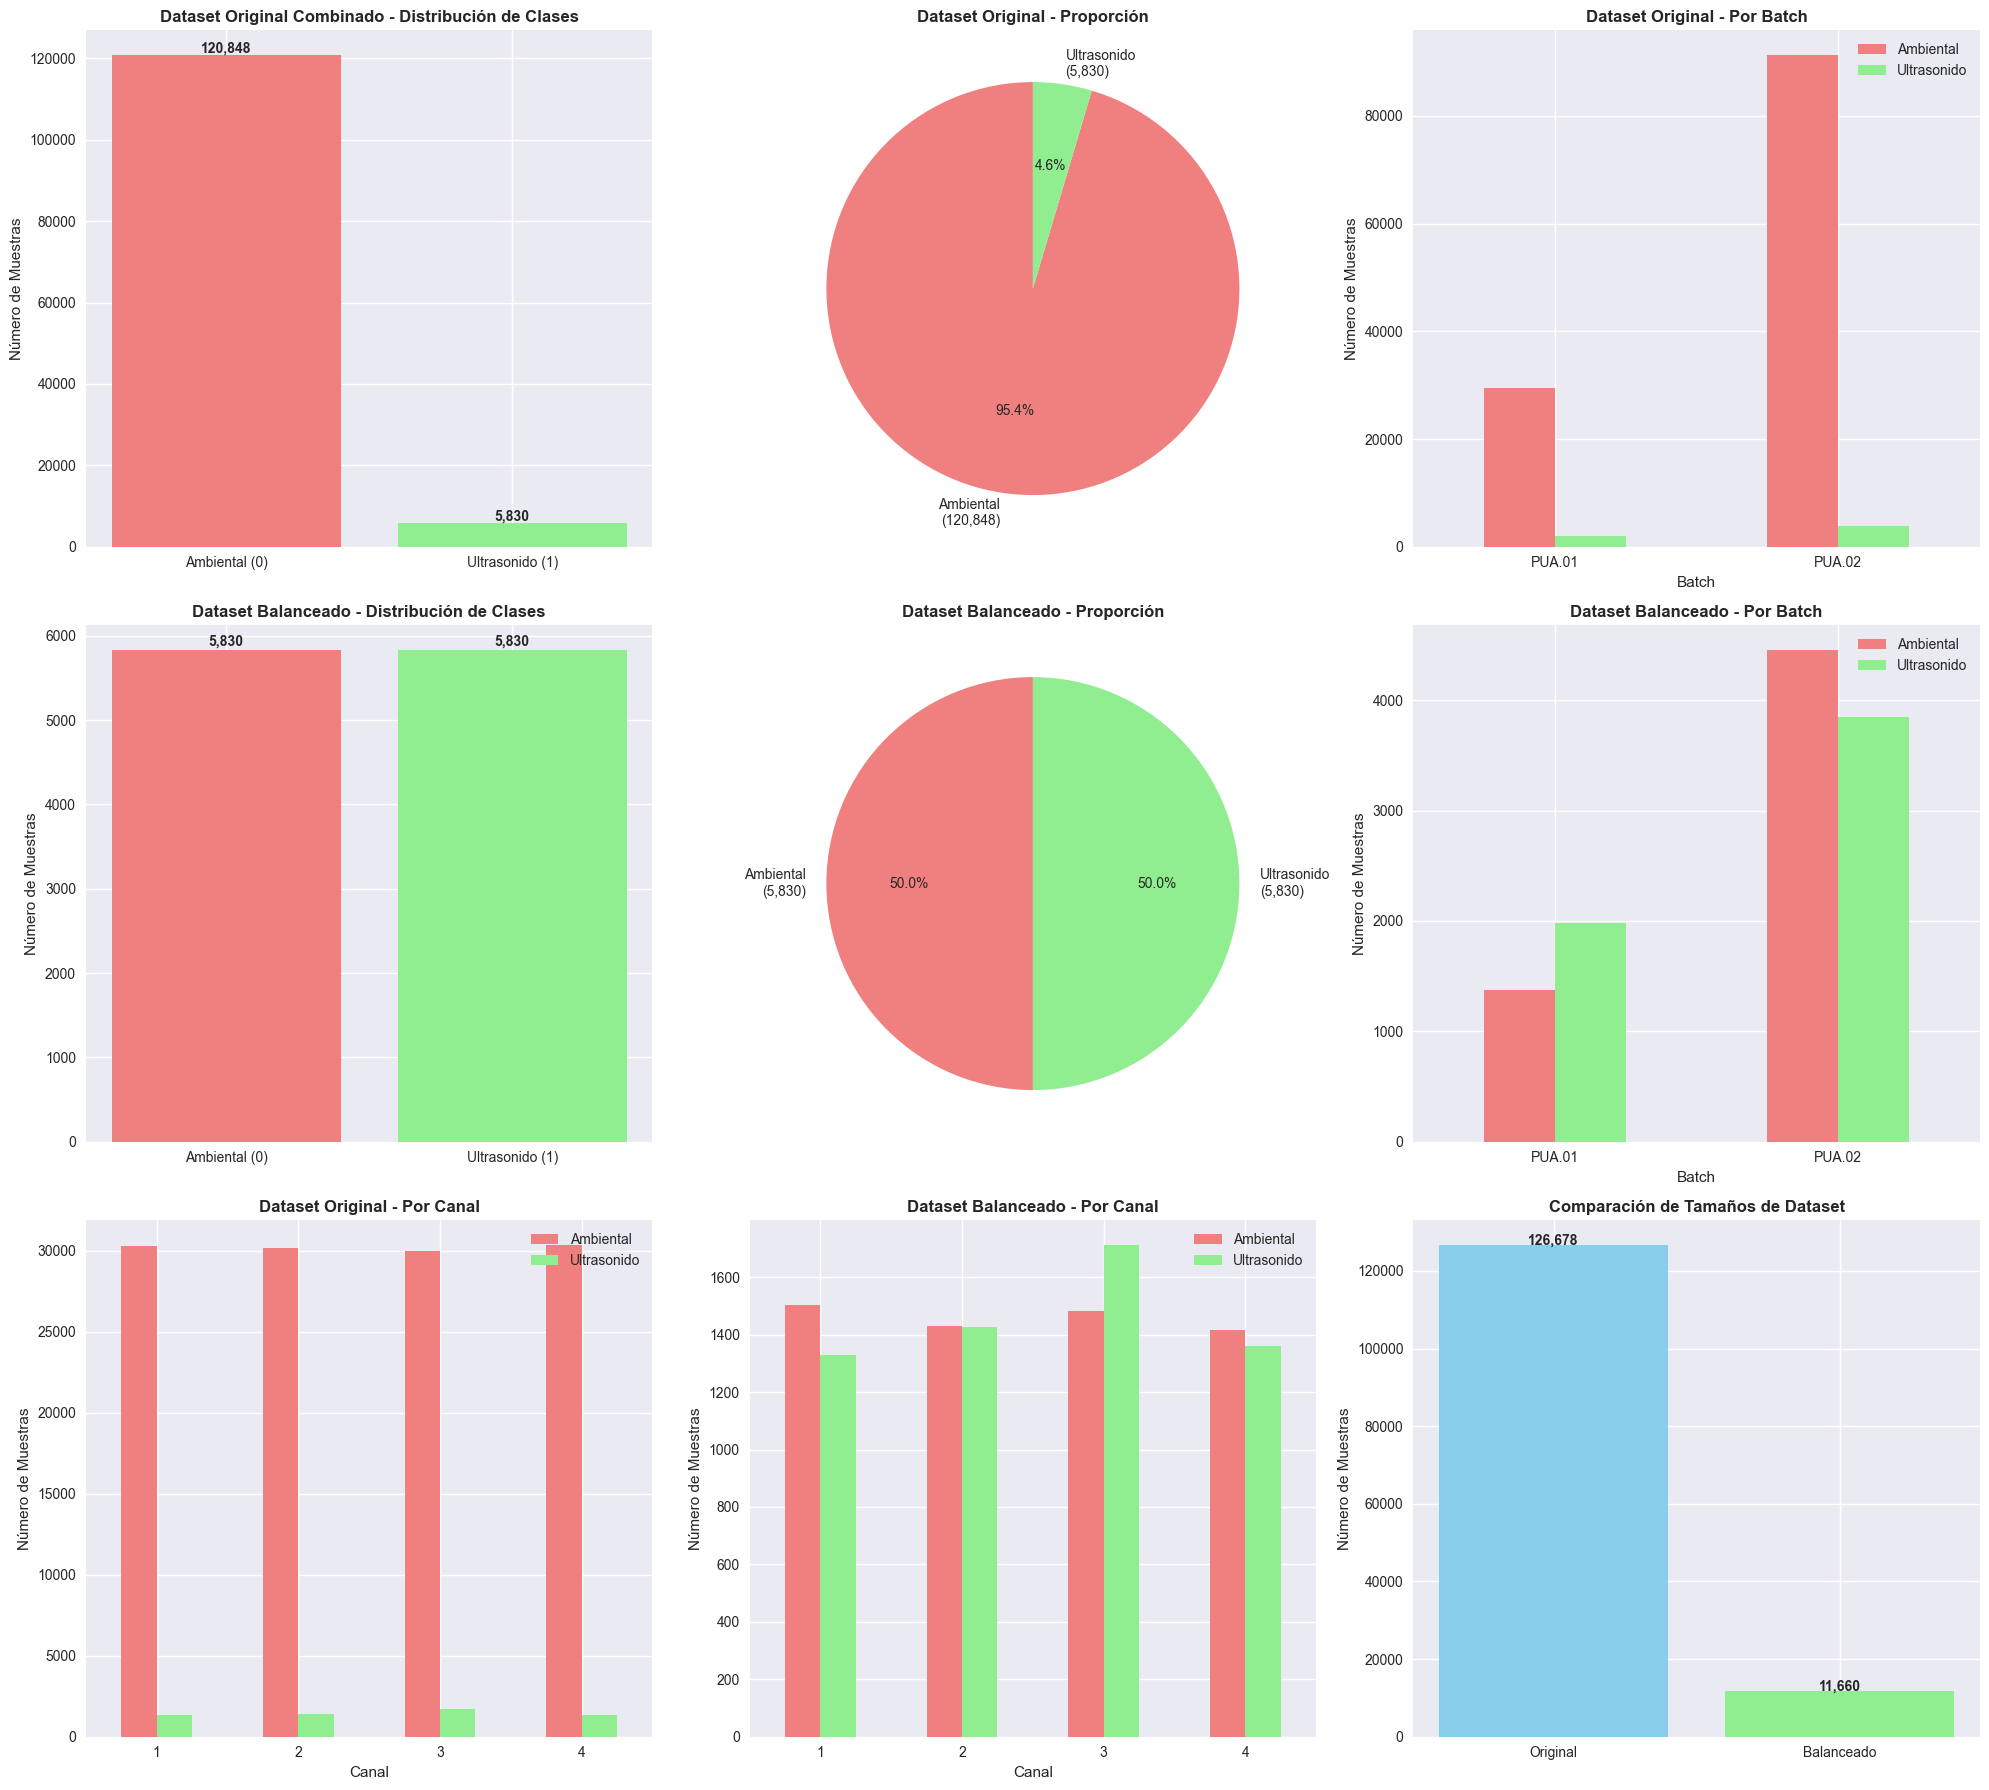

📊 COMPARACIÓN DE DATASETS (PUA.01 + PUA.02):

📈 Dataset Original Combinado:
   Total muestras: 126,678
   Ultrasonidos: 5,830 (4.6%)
   Ambientales: 120,848 (95.4%)
   Ratio desbalance: 20.73:1
   Batches: ['PUA.01', 'PUA.02']

⚖️  Dataset Balanceado:
   Total muestras: 11,660
   Ultrasonidos: 5,830 (50.0%)
   Ambientales: 5,830 (50.0%)
   Ratio balance: 1:1 ✅
   Batches representados: ['PUA.01', 'PUA.02']

📊 Estadísticas por batch (Original):
   PUA.01: 31,515 muestras (1,979 ultrasonidos - 6.3%, 29,536 ambientales - 93.7%)
   PUA.02: 95,163 muestras (3,851 ultrasonidos - 4.0%, 91,312 ambientales - 96.0%)

⚖️  Estadísticas por batch (Balanceado):
   PUA.01: 3,354 muestras (1,979 ultrasonidos - 59.0%, 1,375 ambientales - 41.0%)
   PUA.02: 8,306 muestras (3,851 ultrasonidos - 46.4%, 4,455 ambientales - 53.6%)


In [21]:
# Visualizar distribución antes y después del balanceado (PUA.01 + PUA.02)
if not combined_dataset.empty and not balanced_dataset.empty:
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    
    # FILA 1: Dataset original combinado (PUA.01 + PUA.02)
    # Distribución de clases original
    original_counts = combined_dataset['label'].value_counts()
    axes[0,0].bar(['Ambiental (0)', 'Ultrasonido (1)'], original_counts.values, 
                 color=['lightcoral', 'lightgreen'])
    axes[0,0].set_title('Dataset Original Combinado - Distribución de Clases', fontweight='bold')
    axes[0,0].set_ylabel('Número de Muestras')
    for i, v in enumerate(original_counts.values):
        axes[0,0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')
    
    # Pie chart original
    labels_orig = [f'Ambiental\n({original_counts[0]:,})', f'Ultrasonido\n({original_counts[1]:,})']
    axes[0,1].pie(original_counts.values, labels=labels_orig, colors=['lightcoral', 'lightgreen'], 
                 autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Dataset Original - Proporción', fontweight='bold')
    
    # Distribución por batch (original)
    batch_dist_orig = combined_dataset.groupby(['batch', 'label']).size().unstack(fill_value=0)
    batch_dist_orig.plot(kind='bar', ax=axes[0,2], color=['lightcoral', 'lightgreen'])
    axes[0,2].set_title('Dataset Original - Por Batch', fontweight='bold')
    axes[0,2].set_xlabel('Batch')
    axes[0,2].set_ylabel('Número de Muestras')
    axes[0,2].legend(['Ambiental', 'Ultrasonido'])
    axes[0,2].tick_params(axis='x', rotation=0)
    
    # FILA 2: Dataset balanceado
    # Distribución de clases balanceada
    balanced_counts = balanced_dataset['label'].value_counts()
    axes[1,0].bar(['Ambiental (0)', 'Ultrasonido (1)'], balanced_counts.values, 
                 color=['lightcoral', 'lightgreen'])
    axes[1,0].set_title('Dataset Balanceado - Distribución de Clases', fontweight='bold')
    axes[1,0].set_ylabel('Número de Muestras')
    for i, v in enumerate(balanced_counts.values):
        axes[1,0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')
    
    # Pie chart balanceado
    labels_bal = [f'Ambiental\n({balanced_counts[0]:,})', f'Ultrasonido\n({balanced_counts[1]:,})']
    axes[1,1].pie(balanced_counts.values, labels=labels_bal, colors=['lightcoral', 'lightgreen'], 
                 autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Dataset Balanceado - Proporción', fontweight='bold')
    
    # Distribución por batch (balanceado)
    batch_dist_bal = balanced_dataset.groupby(['batch', 'label']).size().unstack(fill_value=0)
    batch_dist_bal.plot(kind='bar', ax=axes[1,2], color=['lightcoral', 'lightgreen'])
    axes[1,2].set_title('Dataset Balanceado - Por Batch', fontweight='bold')
    axes[1,2].set_xlabel('Batch')
    axes[1,2].set_ylabel('Número de Muestras')
    axes[1,2].legend(['Ambiental', 'Ultrasonido'])
    axes[1,2].tick_params(axis='x', rotation=0)
    
    # FILA 3: Análisis por canal
    # Distribución por canal (original)
    channel_dist_orig = combined_dataset.groupby(['channel', 'label']).size().unstack(fill_value=0)
    channel_dist_orig.plot(kind='bar', ax=axes[2,0], color=['lightcoral', 'lightgreen'])
    axes[2,0].set_title('Dataset Original - Por Canal', fontweight='bold')
    axes[2,0].set_xlabel('Canal')
    axes[2,0].set_ylabel('Número de Muestras')
    axes[2,0].legend(['Ambiental', 'Ultrasonido'])
    axes[2,0].tick_params(axis='x', rotation=0)
    
    # Distribución por canal (balanceado)
    channel_dist_bal = balanced_dataset.groupby(['channel', 'label']).size().unstack(fill_value=0)
    channel_dist_bal.plot(kind='bar', ax=axes[2,1], color=['lightcoral', 'lightgreen'])
    axes[2,1].set_title('Dataset Balanceado - Por Canal', fontweight='bold')
    axes[2,1].set_xlabel('Canal')
    axes[2,1].set_ylabel('Número de Muestras')
    axes[2,1].legend(['Ambiental', 'Ultrasonido'])
    axes[2,1].tick_params(axis='x', rotation=0)
    
    # Comparación de tamaños
    comparison_data = {
        'Original': len(combined_dataset),
        'Balanceado': len(balanced_dataset)
    }
    axes[2,2].bar(comparison_data.keys(), comparison_data.values(), 
                 color=['skyblue', 'lightgreen'])
    axes[2,2].set_title('Comparación de Tamaños de Dataset', fontweight='bold')
    axes[2,2].set_ylabel('Número de Muestras')
    for i, (k, v) in enumerate(comparison_data.items()):
        axes[2,2].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas comparativas detalladas
    print("📊 COMPARACIÓN DE DATASETS (PUA.01 + PUA.02):")
    print("="*60)
    
    print(f"\n📈 Dataset Original Combinado:")
    print(f"   Total muestras: {len(combined_dataset):,}")
    print(f"   Ultrasonidos: {original_counts[1]:,} ({original_counts[1]/len(combined_dataset)*100:.1f}%)")
    print(f"   Ambientales: {original_counts[0]:,} ({original_counts[0]/len(combined_dataset)*100:.1f}%)")
    print(f"   Ratio desbalance: {original_counts.max()/original_counts.min():.2f}:1")
    print(f"   Batches: {sorted(combined_dataset['batch'].unique())}")
    
    print(f"\n⚖️  Dataset Balanceado:")
    print(f"   Total muestras: {len(balanced_dataset):,}")
    print(f"   Ultrasonidos: {balanced_counts[1]:,} ({balanced_counts[1]/len(balanced_dataset)*100:.1f}%)")
    print(f"   Ambientales: {balanced_counts[0]:,} ({balanced_counts[0]/len(balanced_dataset)*100:.1f}%)")
    print(f"   Ratio balance: 1:1 ✅")
    print(f"   Batches representados: {sorted(balanced_dataset['batch'].unique())}")
    
    # Mostrar estadísticas por batch en dataset original
    print(f"\n📊 Estadísticas por batch (Original):")
    for batch in sorted(combined_dataset['batch'].unique()):
        batch_data = combined_dataset[combined_dataset['batch'] == batch]
        ultras = len(batch_data[batch_data['label'] == 1])
        ambien = len(batch_data[batch_data['label'] == 0])
        total = len(batch_data)
        ratio = ultras / total * 100 if total > 0 else 0
        print(f"   {batch}: {total:,} muestras ({ultras:,} ultrasonidos - {ratio:.1f}%, {ambien:,} ambientales - {100-ratio:.1f}%)")
    
    # Mostrar estadísticas por batch en dataset balanceado
    print(f"\n⚖️  Estadísticas por batch (Balanceado):")
    for batch in sorted(balanced_dataset['batch'].unique()):
        batch_data = balanced_dataset[balanced_dataset['batch'] == batch]
        ultras = len(batch_data[batch_data['label'] == 1])
        ambien = len(batch_data[batch_data['label'] == 0])
        total = len(batch_data)
        ratio = ultras / total * 100 if total > 0 else 0
        print(f"   {batch}: {total:,} muestras ({ultras:,} ultrasonidos - {ratio:.1f}%, {ambien:,} ambientales - {100-ratio:.1f}%)")
    
else:
    print("❌ No hay suficientes datos para crear visualizaciones")

## 3. Creación del CSV Final y Análisis Temporal

In [22]:
# Crear y guardar CSV final del dataset balanceado
def save_balanced_dataset_csv(df, output_path="../data/plant_ultrasonic_dataset_balanced.csv"):
    """
    Guardar el dataset balanceado en formato CSV
    
    Args:
        df: DataFrame balanceado
        output_path: Ruta de salida del CSV
    
    Returns:
        String con la ruta del archivo guardado
    """
    if df.empty:
        print("❌ DataFrame vacío, no se puede guardar")
        return None
    
    # Preparar columnas finales para el CSV
    final_df = df[['filename', 'full_path', 'session', 'batch', 'channel', 
                   'datetime', 'date', 'time', 'label', 'label_text', 
                   'has_png', 'png_path', 'file_size']].copy()
    
    # Agregar columnas adicionales útiles
    final_df['hour'] = final_df['datetime'].dt.hour
    final_df['day_of_week'] = final_df['datetime'].dt.dayofweek
    final_df['day_name'] = final_df['datetime'].dt.day_name()
    
    # Agregar ID único
    final_df['sample_id'] = range(1, len(final_df) + 1)
    
    # Reorganizar columnas
    columns_order = ['sample_id', 'filename', 'full_path', 'png_path', 'session', 'batch', 
                    'channel', 'datetime', 'date', 'time', 'hour', 'day_of_week', 'day_name',
                    'label', 'label_text', 'has_png', 'file_size']
    
    final_df = final_df[columns_order]
    
    # Guardar CSV
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    final_df.to_csv(output_path, index=False, encoding='utf-8')
    
    print(f"✅ Dataset guardado en: {output_path}")
    print(f"   Tamaño del archivo: {output_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"   Filas: {len(final_df):,}")
    print(f"   Columnas: {len(final_df.columns)}")
    
    return str(output_path)

# Guardar dataset balanceado
if not balanced_dataset.empty:
    csv_path = save_balanced_dataset_csv(balanced_dataset)
    
    # Mostrar estructura final del CSV
    print(f"\n📋 Estructura del CSV final:")
    print(balanced_dataset.dtypes)
    
    print(f"\n📄 Primeras 5 filas del dataset final:")
    display_cols = ['sample_id', 'filename', 'session', 'channel', 'date', 'hour', 'label_text']
    if 'sample_id' in balanced_dataset.columns:
        print(balanced_dataset[display_cols].head())
    else:
        # Si no se agregó sample_id aún, mostrar sin él
        print(balanced_dataset[['filename', 'session', 'channel', 'date', 'label_text']].head())
        
else:
    print("❌ No hay dataset balanceado para guardar")
    csv_path = None

✅ Dataset guardado en: ../data/plant_ultrasonic_dataset_balanced.csv
   Tamaño del archivo: 2.62 MB
   Filas: 11,660
   Columnas: 17

📋 Estructura del CSV final:
filename              object
full_path             object
session               object
batch                 object
channel                int64
datetime      datetime64[ns]
date                  object
time                  object
has_png                 bool
png_path              object
label                  int64
label_text            object
file_size              int64
dtype: object

📄 Primeras 5 filas del dataset final:
                         filename session  channel        date  \
0  ch2PUA_2025-03-02_07-56-48.wav  PUA083        2  2025-03-02   
1  ch1PUA_2025-01-21_21-42-39.wav  PUA073        1  2025-01-21   
2  ch2PUA_2025-03-09_14-52-20.wav  PUA084        2  2025-03-09   
3  ch4PUA_2025-03-04_01-39-54.wav  PUA083        4  2025-03-04   
4  ch1PUA_2025-01-04_22-52-08.wav  PUA067        1  2025-01-04   

           

📅 Análisis temporal con 11,660 muestras
   Período: 2024-11-29 a 2025-04-16
   Días únicos: 134


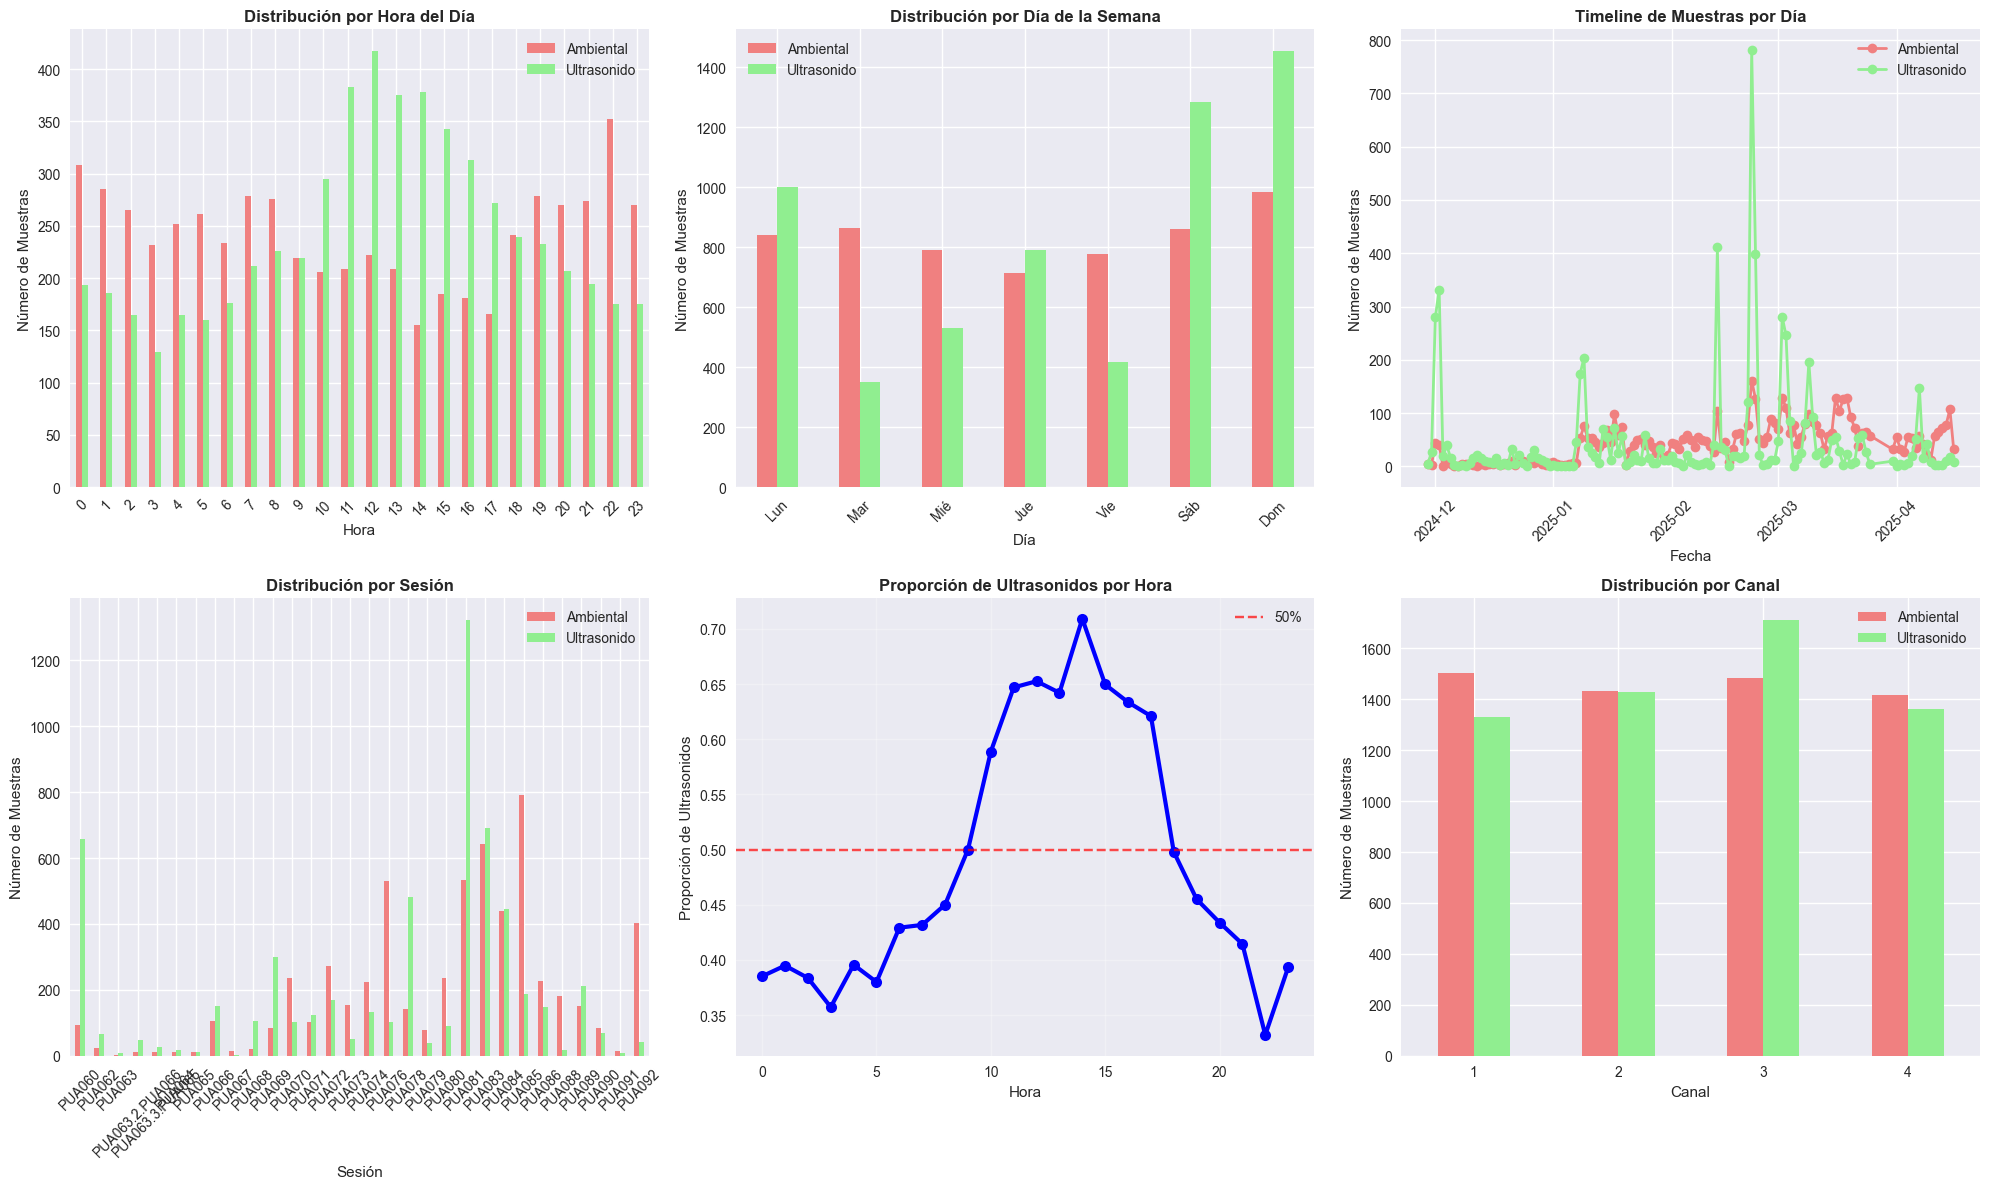


🕐 ANÁLISIS TEMPORAL DETALLADO:

⏰ Por horas:
   Mayor actividad de ultrasonidos: 14:00 (70.9%)
   Menor actividad de ultrasonidos: 22:00 (33.2%)

📡 Por canales:
   Canal 1: 2,831 muestras, 46.9% ultrasonidos
   Canal 2: 2,859 muestras, 49.9% ultrasonidos
   Canal 3: 3,194 muestras, 53.6% ultrasonidos
   Canal 4: 2,776 muestras, 49.0% ultrasonidos

🔬 Por sesiones (top 5):
         Total  Ratio_Ultrasonidos
session                           
PUA081    1855               0.713
PUA083    1334               0.517
PUA085     979               0.192
PUA084     882               0.503
PUA060     750               0.876


In [23]:
# Análisis temporal del dataset balanceado
if not balanced_dataset.empty and balanced_dataset['datetime'].notna().any():
    
    # Preparar datos temporales
    temporal_df = balanced_dataset.dropna(subset=['datetime']).copy()
    temporal_df['hour'] = temporal_df['datetime'].dt.hour
    temporal_df['day_of_week'] = temporal_df['datetime'].dt.dayofweek
    temporal_df['date_only'] = temporal_df['datetime'].dt.date
    
    print(f"📅 Análisis temporal con {len(temporal_df):,} muestras")
    print(f"   Período: {temporal_df['date_only'].min()} a {temporal_df['date_only'].max()}")
    print(f"   Días únicos: {temporal_df['date_only'].nunique()}")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Distribución por hora del día
    hour_dist = temporal_df.groupby(['hour', 'label']).size().unstack(fill_value=0)
    hour_dist.plot(kind='bar', ax=axes[0,0], color=['lightcoral', 'lightgreen'])
    axes[0,0].set_title('Distribución por Hora del Día', fontweight='bold', fontsize=12)
    axes[0,0].set_xlabel('Hora')
    axes[0,0].set_ylabel('Número de Muestras')
    axes[0,0].legend(['Ambiental', 'Ultrasonido'])
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Distribución por día de la semana
    day_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
    day_dist = temporal_df.groupby(['day_of_week', 'label']).size().unstack(fill_value=0)
    day_dist.index = [day_names[i] if i < len(day_names) else f'Día {i}' for i in day_dist.index]
    day_dist.plot(kind='bar', ax=axes[0,1], color=['lightcoral', 'lightgreen'])
    axes[0,1].set_title('Distribución por Día de la Semana', fontweight='bold', fontsize=12)
    axes[0,1].set_xlabel('Día')
    axes[0,1].set_ylabel('Número de Muestras')
    axes[0,1].legend(['Ambiental', 'Ultrasonido'])
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Timeline diario
    daily_counts = temporal_df.groupby(['date_only', 'label']).size().unstack(fill_value=0)
    daily_counts.plot(ax=axes[0,2], color=['lightcoral', 'lightgreen'], linewidth=2, marker='o')
    axes[0,2].set_title('Timeline de Muestras por Día', fontweight='bold', fontsize=12)
    axes[0,2].set_xlabel('Fecha')
    axes[0,2].set_ylabel('Número de Muestras')
    axes[0,2].legend(['Ambiental', 'Ultrasonido'])
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Distribución por sesión
    session_dist = temporal_df.groupby(['session', 'label']).size().unstack(fill_value=0)
    session_dist.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightgreen'])
    axes[1,0].set_title('Distribución por Sesión', fontweight='bold', fontsize=12)
    axes[1,0].set_xlabel('Sesión')
    axes[1,0].set_ylabel('Número de Muestras')
    axes[1,0].legend(['Ambiental', 'Ultrasonido'])
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Ratio de ultrasonidos por hora
    hour_ratio = temporal_df.groupby('hour')['label'].mean()
    axes[1,1].plot(hour_ratio.index, hour_ratio.values, marker='o', linewidth=3, markersize=8, color='blue')
    axes[1,1].set_title('Proporción de Ultrasonidos por Hora', fontweight='bold', fontsize=12)
    axes[1,1].set_xlabel('Hora')
    axes[1,1].set_ylabel('Proporción de Ultrasonidos')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50%')
    axes[1,1].legend()
    
    # 6. Distribución por canal y tipo
    channel_type_dist = temporal_df.groupby(['channel', 'label']).size().unstack(fill_value=0)
    channel_type_dist.plot(kind='bar', ax=axes[1,2], color=['lightcoral', 'lightgreen'])
    axes[1,2].set_title('Distribución por Canal', fontweight='bold', fontsize=12)
    axes[1,2].set_xlabel('Canal')
    axes[1,2].set_ylabel('Número de Muestras')
    axes[1,2].legend(['Ambiental', 'Ultrasonido'])
    axes[1,2].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas temporales detalladas
    print("\n🕐 ANÁLISIS TEMPORAL DETALLADO:")
    print("="*50)
    
    # Estadísticas por hora
    print(f"\n⏰ Por horas:")
    best_hour = hour_ratio.idxmax()
    worst_hour = hour_ratio.idxmin()
    print(f"   Mayor actividad de ultrasonidos: {best_hour}:00 ({hour_ratio.max():.1%})")
    print(f"   Menor actividad de ultrasonidos: {worst_hour}:00 ({hour_ratio.min():.1%})")
    
    # Estadísticas por canal
    print(f"\n📡 Por canales:")
    for channel in sorted(temporal_df['channel'].unique()):
        channel_data = temporal_df[temporal_df['channel'] == channel]
        ultrasound_ratio = channel_data['label'].mean()
        count = len(channel_data)
        print(f"   Canal {channel}: {count:,} muestras, {ultrasound_ratio:.1%} ultrasonidos")
    
    # Estadísticas por sesión
    print(f"\n🔬 Por sesiones (top 5):")
    session_stats = temporal_df.groupby('session').agg({
        'label': ['count', 'mean']
    }).round(3)
    session_stats.columns = ['Total', 'Ratio_Ultrasonidos']
    session_stats = session_stats.sort_values('Total', ascending=False)
    print(session_stats.head())
    
else:
    print("❌ No hay datos temporales válidos para análisis")

## 4. Análisis de Archivos de Audio Disponibles

In [24]:
# Buscar archivos de audio para análisis en AMBOS batches
def find_sample_audio_files_from_both_batches(n_samples=6):
    """Buscar archivos de audio de muestra de ambos batches PUA.01 y PUA.02"""
    audio_files = []
    
    # Buscar en PUA.02
    pua02_path = Path(data_path) / "PUA.02" / "audiofiles"
    if pua02_path.exists():
        for session_dir in pua02_path.iterdir():
            if session_dir.is_dir() and session_dir.name.startswith('PUA'):
                wav_files = list(session_dir.glob("*.wav"))
                if wav_files:
                    audio_files.extend(wav_files[:1])  # 1 por sesión de PUA.02
                    if len(audio_files) >= n_samples // 2:
                        break
    
    # Buscar en PUA.01
    pua01_path = Path(data_path) / "PUA.01" / "audiofiles"
    if pua01_path.exists():
        for session_dir in pua01_path.iterdir():
            if session_dir.is_dir() and session_dir.name.startswith('PUA'):
                wav_files = list(session_dir.glob("*.wav"))
                if wav_files:
                    audio_files.extend(wav_files[:1])  # 1 por sesión de PUA.01
                    if len(audio_files) >= n_samples:
                        break
    
    return audio_files[:n_samples]

sample_audio_files = find_sample_audio_files_from_both_batches(6)
print(f"Encontrados {len(sample_audio_files)} archivos de audio de muestra de ambos batches")

if sample_audio_files:
    print(f"\n📊 Archivos de muestra por batch:")
    batch_counts = {}
    
    for audio_path in sample_audio_files:
        file_size = audio_path.stat().st_size / (1024*1024)  # MB
        batch = "PUA.02" if "PUA.02" in str(audio_path) else "PUA.01"
        session = audio_path.parent.name
        
        if batch not in batch_counts:
            batch_counts[batch] = 0
        batch_counts[batch] += 1
        
        print(f"🔊 {audio_path.name} ({file_size:.2f} MB)")
        print(f"   📁 Batch: {batch} | Sesión: {session}")
    
    print(f"\n📈 Distribución de muestras:")
    for batch, count in batch_counts.items():
        print(f"   {batch}: {count} archivos")
        
else:
    print("❌ No se encontraron archivos de audio en ningún batch")

Encontrados 6 archivos de audio de muestra de ambos batches

📊 Archivos de muestra por batch:
🔊 ch1PUA_2025-04-13_01-26-45.wav (0.15 MB)
   📁 Batch: PUA.02 | Sesión: PUA092
🔊 ch1PUA_2025-04-02_12-56-40.wav (0.15 MB)
   📁 Batch: PUA.02 | Sesión: PUA088
🔊 ch3PUA_2025-03-25_05-55-36.wav (0.15 MB)
   📁 Batch: PUA.02 | Sesión: PUA086
🔊 ch1PUA_2024-11-29_15-41-23.wav (0.18 MB)
   📁 Batch: PUA.01 | Sesión: PUA060
🔊 ch3PUA_2025-01-04_18-06-15.wav (0.15 MB)
   📁 Batch: PUA.01 | Sesión: PUA067
🔊 ch3PUA_2025-01-08_20-58-57.wav (0.15 MB)
   📁 Batch: PUA.01 | Sesión: PUA069

📈 Distribución de muestras:
   PUA.02: 3 archivos
   PUA.01: 3 archivos


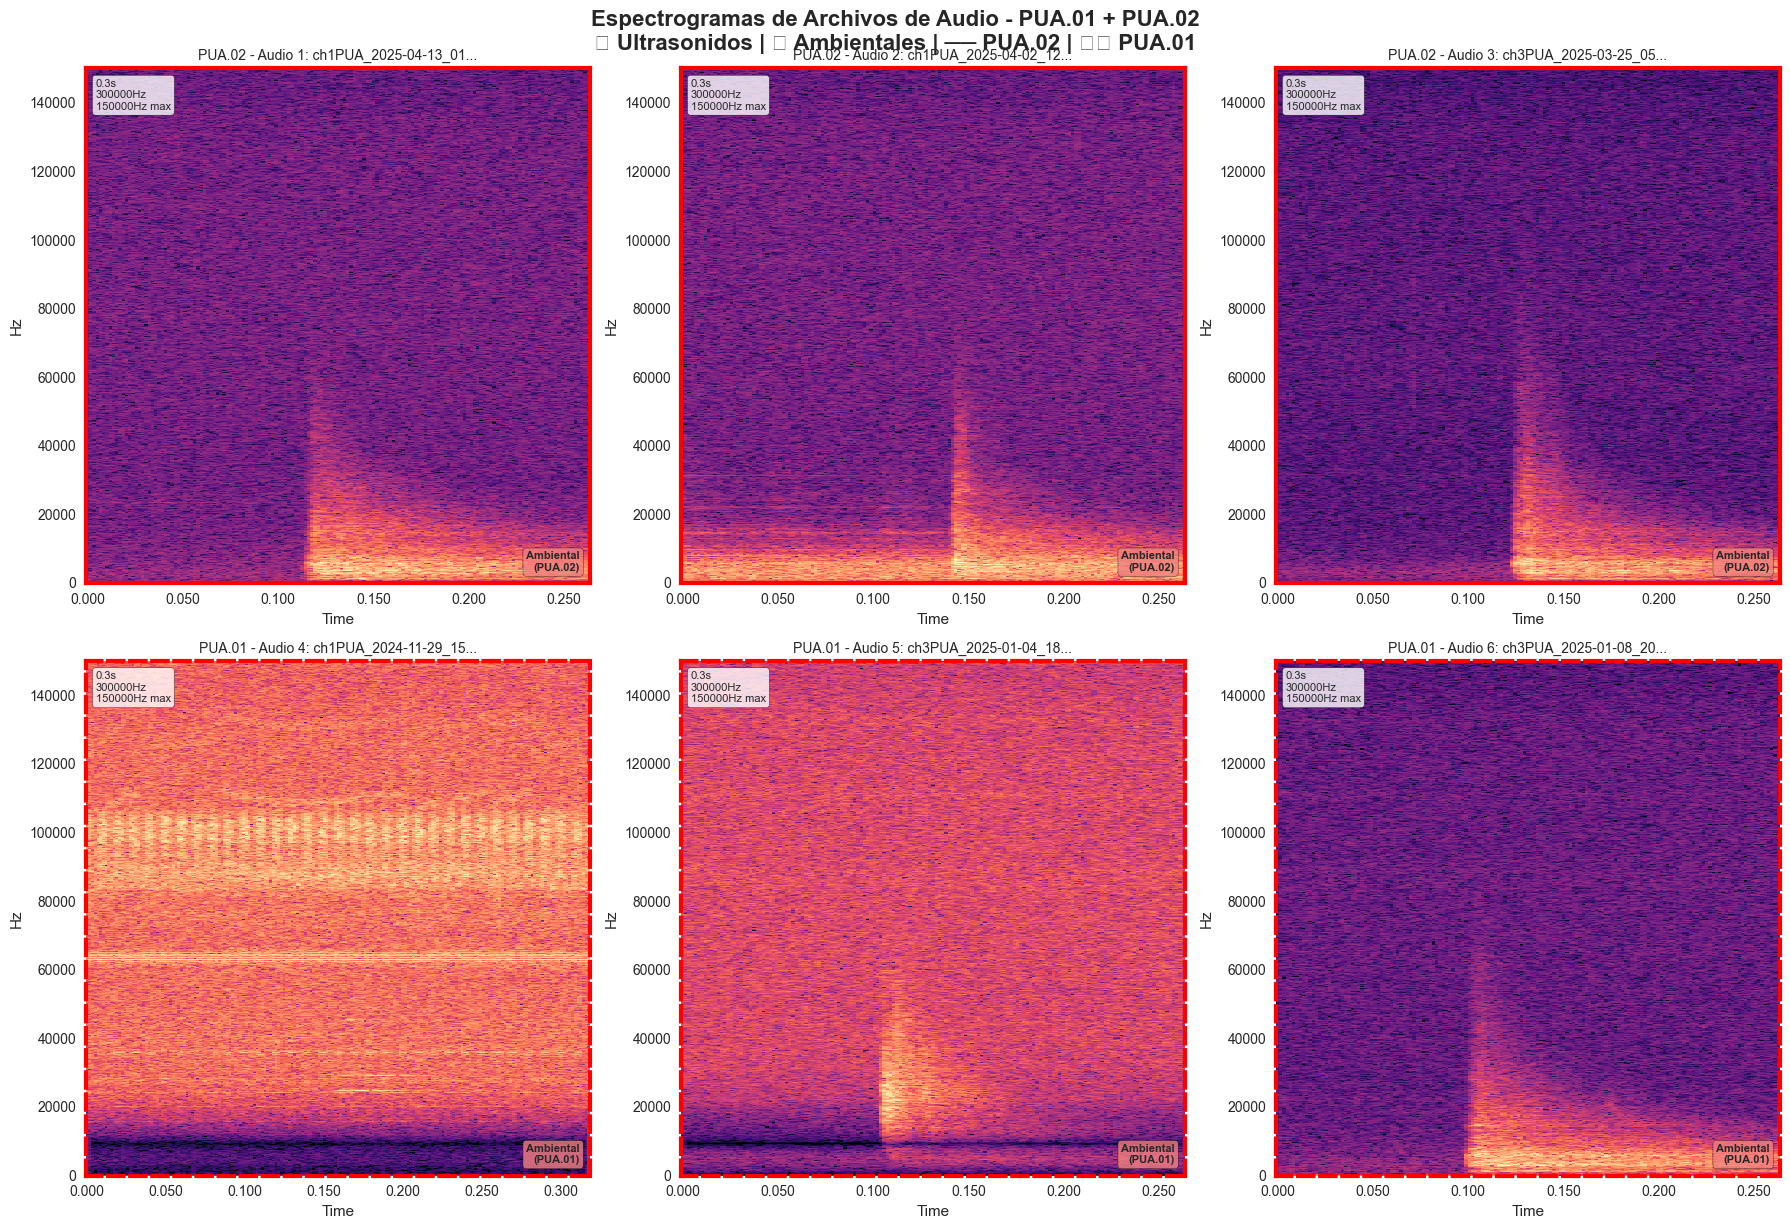


📊 Estadísticas de archivos de audio por batch:

   📁 PUA.01:
      Archivos en muestra: 3
      Tamaño total: 0.48 MB
      Promedio por archivo: 0.16 MB


NameError: name 'audio_file' is not defined

In [27]:
# Análisis y visualización de archivos de audio de muestra de ambos batches
if sample_audio_files:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, audio_path in enumerate(sample_audio_files):
        try:
            # Cargar audio (solo primeros 5 segundos para eficiencia)
            y, sr = librosa.load(str(audio_path), duration=5.0, sr=None)
            
            if len(y) > 0:
                # Crear espectrograma
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                
                # Mostrar espectrograma
                img = librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=axes[i])
                
                # Determinar batch
                batch = "PUA.02" if "PUA.02" in str(audio_path) else "PUA.01"
                axes[i].set_title(f'{batch} - Audio {i+1}: {audio_path.name[:20]}...', fontsize=10)
                
                # Información del audio
                duration = len(y) / sr
                max_freq = sr // 2
                axes[i].text(0.02, 0.98, f'{duration:.1f}s\n{sr}Hz\n{max_freq}Hz max', 
                           transform=axes[i].transAxes, 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           verticalalignment='top', fontsize=8)
                
                # Detectar si es ultrasonido o ambiental basado en nuestro criterio
                filename = audio_path.name
                filename_base = filename.replace('.wav', '')
                # Buscar PNG en la misma carpeta de la sesión
                png_path = audio_path.parent / f"{filename_base}.png"
                audio_type = "Ultrasonido" if png_path.exists() else "Ambiental"
                
                # Añadir borde de color según tipo y batch
                border_color = 'green' if audio_type == "Ultrasonido" else 'red'
                line_style = '-' if batch == "PUA.02" else '--'  # Línea sólida para PUA.02, discontinua para PUA.01
                
                for spine in axes[i].spines.values():
                    spine.set_edgecolor(border_color)
                    spine.set_linewidth(3)
                    spine.set_linestyle(line_style)
                
                # Etiqueta con tipo y batch
                label_text = f"{audio_type}\n({batch})"
                axes[i].text(0.98, 0.02, label_text, 
                           transform=axes[i].transAxes, 
                           bbox=dict(boxstyle='round', 
                                   facecolor='lightgreen' if audio_type == "Ultrasonido" else 'lightcoral', 
                                   alpha=0.8),
                           verticalalignment='bottom', horizontalalignment='right', 
                           fontsize=8, fontweight='bold')
            else:
                axes[i].text(0.5, 0.5, 'Audio vacío', 
                           transform=axes[i].transAxes, ha='center', va='center')
                axes[i].set_title(f'Audio {i+1}: Error')
                
        except Exception as e:
            batch = "PUA.02" if "PUA.02" in str(audio_path) else "PUA.01"
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'{batch} - Audio {i+1}: Error de carga')
    
    plt.tight_layout()
    plt.suptitle('Espectrogramas de Archivos de Audio - PUA.01 + PUA.02\n🟢 Ultrasonidos | 🔴 Ambientales | ── PUA.02 | ╌╌ PUA.01', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Estadísticas de los archivos de audio por batch
    print("\n📊 Estadísticas de archivos de audio por batch:")
    
    pua01_files = [f for f in sample_audio_files if "PUA.01" in str(f)]
    pua02_files = [f for f in sample_audio_files if "PUA.02" in str(f)]
    
    for batch_name, files in [("PUA.01", pua01_files), ("PUA.02", pua02_files)]:
        if files:
            total_size = sum(f.stat().st_size for f in files) / (1024*1024)
            print(f"\n   📁 {batch_name}:")
            print(f"      Archivos en muestra: {len(files)}")
            print(f"      Tamaño total: {total_size:.2f} MB")
            print(f"      Promedio por archivo: {total_size/len(files):.2f} MB")
            
            # Análizar tipos por criterio PNG
            ultrasonidos_count = 0
            ambientales_count = 0
            
            # Detectar si es ultrasonido o ambiental basado en criterio PNG en misma carpeta
            filename_base = audio_file#.name.replace('.wav', '')
            png_path = audio_file.parent / f"{filename_base}.png"
            if png_path.exists():
                ultrasonidos_count += 1
            else:
                ambientales_count += 1
            
            print(f"      Ultrasonidos: {ultrasonidos_count}, Ambientales: {ambientales_count}")
    
else:
    print("❌ No se encontraron archivos de audio para visualizar")

## 5. Análisis Detallado de Características de Audio

In [ ]:
# Usar los archivos de audio ya encontrados para análisis detallado
print(f"📊 Análisis detallado con {len(sample_audio_files)} archivos de audio")

if sample_audio_files:
    for i, audio_file in enumerate(sample_audio_files[:3]):
        file_size = audio_file.stat().st_size / (1024*1024)  # MB
        session = audio_file.parent.name
        
        # Determinar tipo basado en PNG en la misma carpeta de sesión
        filename_base = audio_file.name.replace('.wav', '')
        png_path = audio_file.parent / f"{filename_base}.png"
        audio_type = "🌱 Ultrasonido de Planta" if png_path.exists() else "🌍 Sonido Ambiental"
        
        print(f"\n🔊 Archivo {i+1}: {audio_file.name}")
        print(f"   📁 Sesión: {session}")
        print(f"   📏 Tamaño: {file_size:.2f} MB")
        print(f"   🏷️  Tipo: {audio_type}")
        if png_matches:
            print(f"   ? Espectrograma: {png_matches[0].name}")
else:
    print("❌ No se encontraron archivos de audio para análisis detallado")

Encontrados 3 archivos de audio de muestra
🔊 ch1PUA_2025-04-13_01-26-45.wav
🔊 ch1PUA_2025-04-12_15-51-23.wav
🔊 ch1PUA_2025-04-12_21-42-29.wav



🔊 ch1PUA_2025-04-13_01-26-45.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.26s
   📊 Sample Rate: 300,000 Hz
   📈 Amplitud máxima: 0.9647
   📊 RMS: 0.1267
   💾 Samples: 79,152

🔊 ch1PUA_2025-04-02_12-56-40.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.26s
   📊 Sample Rate: 300,000 Hz
   📈 Amplitud máxima: 1.0000
   📊 RMS: 0.1491
   💾 Samples: 79,152

🔊 ch3PUA_2025-03-25_05-55-36.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.26s
   📊 Sample Rate: 300,000 Hz
   📈 Amplitud máxima: 1.0000
   📊 RMS: 0.1564
   💾 Samples: 79,152

🔊 ch1PUA_2024-11-29_15-41-23.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.32s
   📊 Sample Rate: 300,000 Hz
   📈 Amplitud máxima: 0.0666
   📊 RMS: 0.0115
   💾 Samples: 95,536

🔊 ch3PUA_2025-03-25_05-55-36.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.26s
   📊 Sample Rate: 300,000 Hz
   📈 Amplitud máxima: 1.0000
   📊 RMS: 0.1564
   💾 Samples: 79,152

🔊 ch1PUA_2024-11-29_15-41-23.wav:
   🏷️  Tipo: Ambiental
   ⏱️  Duración: 0.32s
   📊 Sample Rate: 300,000 Hz
   📈 

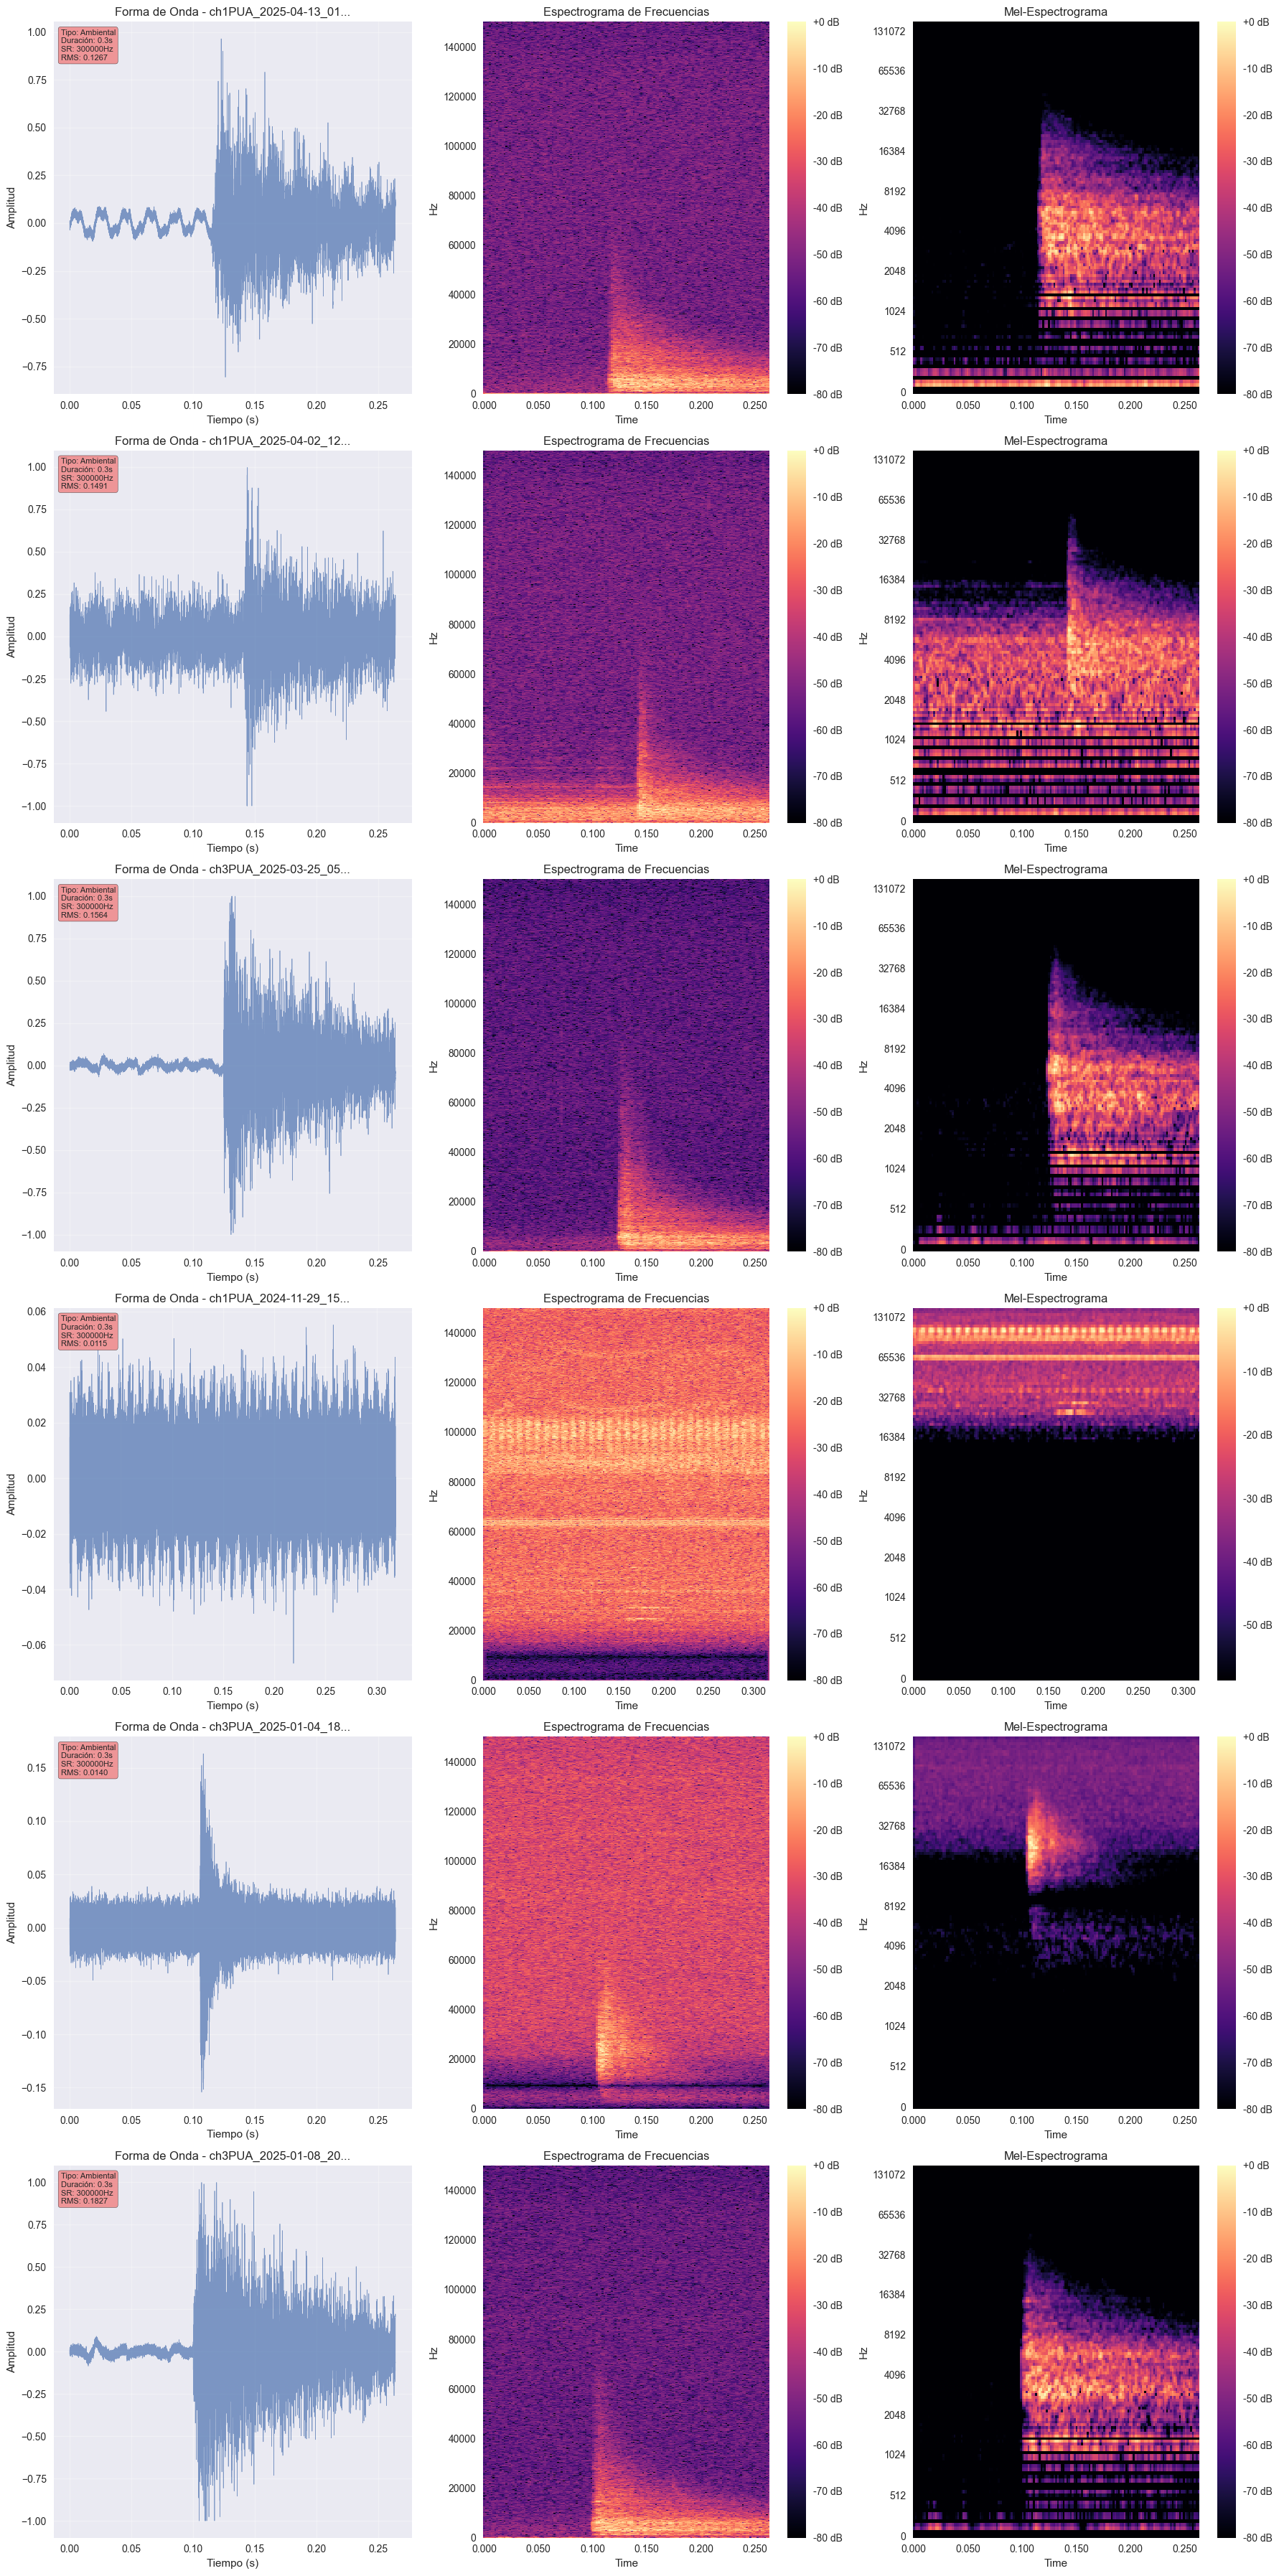


📋 Resumen de estadísticas de audio:
                          archivo       tipo  duracion_s  sample_rate  \
0  ch1PUA_2025-04-13_01-26-45.wav  Ambiental      0.2638       300000   
1  ch1PUA_2025-04-02_12-56-40.wav  Ambiental      0.2638       300000   
2  ch3PUA_2025-03-25_05-55-36.wav  Ambiental      0.2638       300000   
3  ch1PUA_2024-11-29_15-41-23.wav  Ambiental      0.3185       300000   
4  ch3PUA_2025-01-04_18-06-15.wav  Ambiental      0.2638       300000   
5  ch3PUA_2025-01-08_20-58-57.wav  Ambiental      0.2638       300000   

   amplitud_max     rms  
0        0.9647  0.1267  
1        1.0000  0.1491  
2        1.0000  0.1564  
3        0.0666  0.0115  
4        0.1632  0.0140  
5        1.0000  0.1827  


In [28]:
# Análisis detallado de características de audio
if sample_audio_files:
    fig, axes = plt.subplots(len(sample_audio_files), 3, figsize=(18, 6*len(sample_audio_files)))
    if len(sample_audio_files) == 1:
        axes = axes.reshape(1, -1)
    
    audio_stats = []
    
    for i, audio_file in enumerate(sample_audio_files):
        try:
            # Cargar audio completo para análisis
            y, sr = librosa.load(str(audio_file), sr=None)
            
            # 1. Forma de onda
            time = np.linspace(0, len(y)/sr, len(y))
            axes[i, 0].plot(time, y, linewidth=0.5, alpha=0.7)
            axes[i, 0].set_title(f'Forma de Onda - {audio_file.name[:20]}...')
            axes[i, 0].set_xlabel('Tiempo (s)')
            axes[i, 0].set_ylabel('Amplitud')
            axes[i, 0].grid(True, alpha=0.3)
            
            # Estadísticas básicas
            duration = len(y) / sr
            max_amp = np.max(np.abs(y))
            rms = np.sqrt(np.mean(y**2))
            
            # 2. Espectrograma
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            img = librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=axes[i, 1])
            axes[i, 1].set_title('Espectrograma de Frecuencias')
            plt.colorbar(img, ax=axes[i, 1], format='%+2.0f dB')
            
            # 3. Mel-espectrograma
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
            img2 = librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', sr=sr, ax=axes[i, 2])
            axes[i, 2].set_title('Mel-Espectrograma')
            plt.colorbar(img2, ax=axes[i, 2], format='%+2.0f dB')
            
            # Determinar tipo de audio buscando PNG en la misma carpeta
            filename_base = audio_file.name.replace('.wav', '')
            png_path = audio_file.parent / f"{filename_base}.png"
            audio_type = "Ultrasonido" if png_path.exists() else "Ambiental"
            
            # Recopilar estadísticas
            audio_stats.append({
                'archivo': audio_file.name,
                'tipo': audio_type,
                'duracion_s': duration,
                'sample_rate': sr,
                'samples': len(y),
                'amplitud_max': max_amp,
                'rms': rms,
                'tamaño_mb': audio_file.stat().st_size / (1024*1024)
            })
            
            # Información del audio en la gráfica
            info_text = f'Tipo: {audio_type}\nDuración: {duration:.1f}s\nSR: {sr}Hz\nRMS: {rms:.4f}'
            axes[i, 0].text(0.02, 0.98, info_text, 
                           transform=axes[i, 0].transAxes, 
                           bbox=dict(boxstyle='round', 
                                   facecolor='lightgreen' if audio_type == 'Ultrasonido' else 'lightcoral', 
                                   alpha=0.8),
                           verticalalignment='top', fontsize=8)
            
            print(f"\n🔊 {audio_file.name}:")
            print(f"   🏷️  Tipo: {audio_type}")
            print(f"   ⏱️  Duración: {duration:.2f}s")
            print(f"   📊 Sample Rate: {sr:,} Hz")
            print(f"   📈 Amplitud máxima: {max_amp:.4f}")
            print(f"   📊 RMS: {rms:.4f}")
            print(f"   💾 Samples: {len(y):,}")
            
        except Exception as e:
            print(f"❌ Error procesando {audio_file.name}: {e}")
            for j in range(3):
                axes[i, j].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                               transform=axes[i, j].transAxes, ha='center', va='center')
                axes[i, j].set_title(f'Error en {audio_file.name}')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de estadísticas
    if audio_stats:
        stats_df = pd.DataFrame(audio_stats)
        print(f"\n📋 Resumen de estadísticas de audio:")
        print(stats_df[['archivo', 'tipo', 'duracion_s', 'sample_rate', 'amplitud_max', 'rms']].round(4))
        
else:
    print("⚠️  No hay archivos de audio disponibles para análisis detallado")

## 6. Análisis de Correlación entre Variables

In [32]:
# Crear análisis de correlación usando los nombres de archivos
# Extraer características básicas de los nombres de archivos

def extract_file_features(filename):
    """Extraer características básicas del nombre del archivo"""
    features = {}
    
    # Extraer información del dispositivo/canal
    if 'ch1' in filename:
        features['channel'] = 1
    elif 'ch2' in filename:
        features['channel'] = 2
    elif 'ch3' in filename:
        features['channel'] = 3
    elif 'ch4' in filename:
        features['channel'] = 4
    else:
        features['channel'] = 0
    
    # Extraer número de sesión
    if 'PUA060' in filename:
        features['session'] = 60
    elif 'PUA062' in filename:
        features['session'] = 62
    elif 'PUA063' in filename:
        features['session'] = 63
    else:
        features['session'] = 0
    
    return features

classification_df = balanced_dataset.copy()
# Aplicar extracción de características
file_features = classification_df['filename'].apply(extract_file_features)
features_df = pd.DataFrame(file_features.tolist())
analysis_df = pd.concat([classification_df[['label']], features_df], axis=1)

# Agregar características temporales si están disponibles
if 'hour' in classification_df.columns:
    analysis_df['hour'] = classification_df['hour']
if 'day_of_week' in classification_df.columns:
    analysis_df['day_of_week'] = classification_df['day_of_week']

print("📊 Variables para análisis de correlación:")
print(analysis_df.head())
print(f"\nForma: {analysis_df.shape}")

📊 Variables para análisis de correlación:
   label  channel  session
0      1        2        0
1      0        1        0
2      0        2        0
3      1        4        0
4      0        1        0

Forma: (11660, 3)


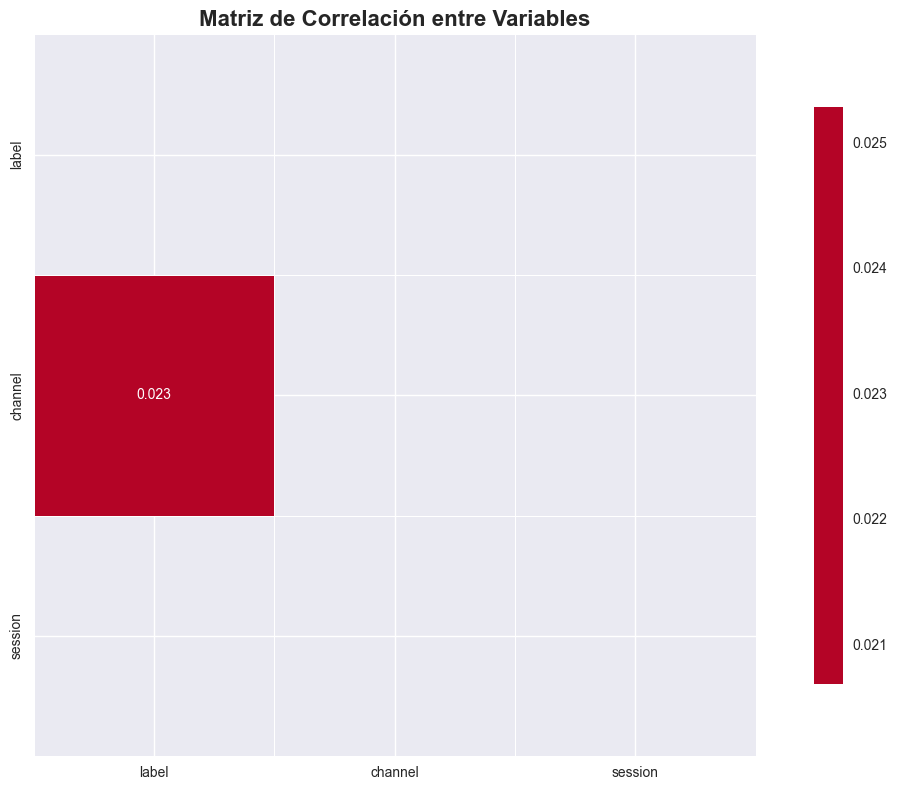


🎯 Correlaciones más fuertes con la variable objetivo (label):
   channel: 0.023
   session: nan


In [33]:
# Matriz de correlación
correlation_matrix = analysis_df.corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlaciones más fuertes con la variable objetivo
label_correlations = correlation_matrix['label'].abs().sort_values(ascending=False)[1:]
print("\n🎯 Correlaciones más fuertes con la variable objetivo (label):")
for var, corr in label_correlations.items():
    print(f"   {var}: {corr:.3f}")

## 7. Análisis por Canal/Dispositivo

In [34]:
# Análisis por canal
channel_analysis = analysis_df.groupby('channel')['label'].agg(['count', 'mean', 'std']).round(3)
channel_analysis.columns = ['Muestras', 'Ratio_Estrés', 'Std_Estrés']

print("📡 Análisis por Canal:")
print(channel_analysis)

# Análisis por sesión
session_analysis = analysis_df.groupby('session')['label'].agg(['count', 'mean', 'std']).round(3)
session_analysis.columns = ['Muestras', 'Ratio_Estrés', 'Std_Estrés']

print("\n🔬 Análisis por Sesión:")
print(session_analysis)

📡 Análisis por Canal:
         Muestras  Ratio_Estrés  Std_Estrés
channel                                    
1            2831         0.469       0.499
2            2859         0.499       0.500
3            3194         0.536       0.499
4            2776         0.490       0.500

🔬 Análisis por Sesión:
         Muestras  Ratio_Estrés  Std_Estrés
session                                    
0           11660           0.5         0.5


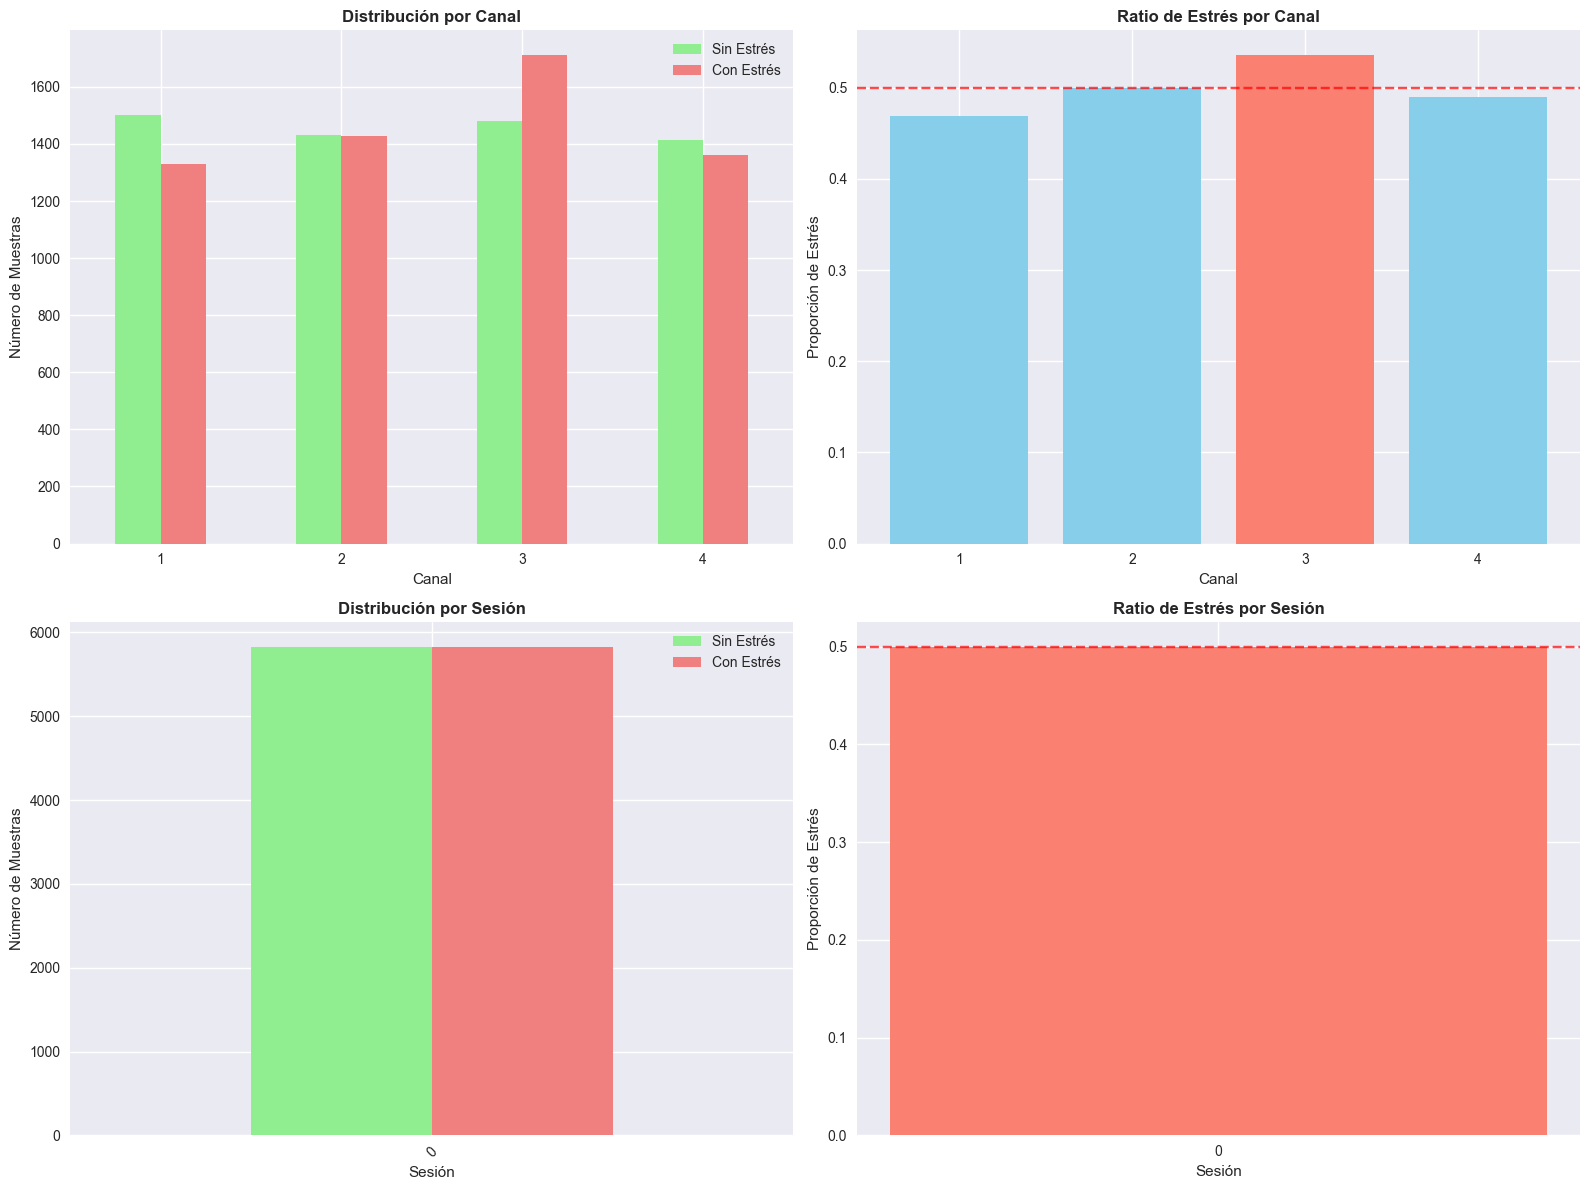

In [35]:
# Visualización por canal y sesión
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución por canal
channel_counts = analysis_df.groupby(['channel', 'label']).size().unstack(fill_value=0)
channel_counts.plot(kind='bar', ax=axes[0,0], color=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Distribución por Canal', fontweight='bold')
axes[0,0].set_xlabel('Canal')
axes[0,0].set_ylabel('Número de Muestras')
axes[0,0].legend(['Sin Estrés', 'Con Estrés'])
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Ratio de estrés por canal
channel_ratio = analysis_df.groupby('channel')['label'].mean()
axes[0,1].bar(range(len(channel_ratio)), channel_ratio.values, 
             color=['skyblue' if x < 0.5 else 'salmon' for x in channel_ratio.values])
axes[0,1].set_title('Ratio de Estrés por Canal', fontweight='bold')
axes[0,1].set_xlabel('Canal')
axes[0,1].set_ylabel('Proporción de Estrés')
axes[0,1].set_xticks(range(len(channel_ratio)))
axes[0,1].set_xticklabels(channel_ratio.index)
axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7)

# 3. Distribución por sesión
session_counts = analysis_df.groupby(['session', 'label']).size().unstack(fill_value=0)
session_counts.plot(kind='bar', ax=axes[1,0], color=['lightgreen', 'lightcoral'])
axes[1,0].set_title('Distribución por Sesión', fontweight='bold')
axes[1,0].set_xlabel('Sesión')
axes[1,0].set_ylabel('Número de Muestras')
axes[1,0].legend(['Sin Estrés', 'Con Estrés'])
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Ratio de estrés por sesión
session_ratio = analysis_df.groupby('session')['label'].mean()
axes[1,1].bar(range(len(session_ratio)), session_ratio.values,
             color=['skyblue' if x < 0.5 else 'salmon' for x in session_ratio.values])
axes[1,1].set_title('Ratio de Estrés por Sesión', fontweight='bold')
axes[1,1].set_xlabel('Sesión')
axes[1,1].set_ylabel('Proporción de Estrés')
axes[1,1].set_xticks(range(len(session_ratio)))
axes[1,1].set_xticklabels(session_ratio.index)
axes[1,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 8. Resumen y Conclusiones

In [41]:
# Generar resumen completo del análisis
print("="*60)
print("📋 RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*60)

# Calcular estadísticas de clases
class_distribution = classification_df['label'].value_counts().sort_index()
class_percentages = classification_df['label'].value_counts(normalize=True).sort_index() * 100
is_balanced = abs(class_distribution[0] - class_distribution[1]) <= 1  # tolerancia 1 muestra

print(f"\n📊 DATASET GENERAL:")
print(f"   • Total de muestras: {len(classification_df):,}")
print(f"   • Clases: Sin estrés ({class_distribution[0]:,}) vs Con estrés ({class_distribution[1]:,})")
print(f"   • Balance: {'✅ Balanceado' if is_balanced else '⚠️ Desbalanceado'} ({class_percentages[0]:.1f}% - {class_percentages[1]:.1f}%)")

if 'temporal_df' in locals() and len(temporal_df) > 0:
    print(f"\n🕐 PATRONES TEMPORALES:")
    print(f"   • Período: {temporal_df['datetime'].min().strftime('%Y-%m-%d')} a {temporal_df['datetime'].max().strftime('%Y-%m-%d')}")
    hour_ratio = temporal_df.groupby('hour')['label'].mean()
    print(f"   • Mayor estrés en hora: {hour_ratio.idxmax()}:00 ({hour_ratio.max():.1%})")
    print(f"   • Menor estrés en hora: {hour_ratio.idxmin()}:00 ({hour_ratio.min():.1%})")

print(f"\n📡 ANÁLISIS POR CANAL:")
for channel in analysis_df['channel'].unique():
    if channel != 0:
        subset = analysis_df[analysis_df['channel'] == channel]
        ratio = subset['label'].mean()
        count = len(subset)
        print(f"   • Canal {channel}: {count:,} muestras, {ratio:.1%} estrés")

print(f"\n🔬 ANÁLISIS POR SESIÓN:")
for session in sorted(analysis_df['session'].unique()):
    if session != 0:
        subset = analysis_df[analysis_df['session'] == session]
        ratio = subset['label'].mean()
        count = len(subset)
        print(f"   • Sesión PUA{session}: {count:,} muestras, {ratio:.1%} estrés")

print(f"\n💡 RECOMENDACIONES:")
if not is_balanced:
    print(f"   • Usar técnicas de balanceamiento (SMOTE, class weights, etc.)")
if 'valid_datetime_df' in locals() and len(valid_datetime_df) > 0:
    print(f"   • Considerar características temporales como features")
print(f"   • Explorar data augmentation para espectrogramas")
print(f"   • Validación cruzada estratificada por sesión/canal")
print(f"   • Modelos ensemble para mayor robustez")

print("\n" + "="*60)

📋 RESUMEN DEL ANÁLISIS EXPLORATORIO

📊 DATASET GENERAL:
   • Total de muestras: 11,660
   • Clases: Sin estrés (5,830) vs Con estrés (5,830)
   • Balance: ✅ Balanceado (50.0% - 50.0%)

🕐 PATRONES TEMPORALES:
   • Período: 2024-11-29 a 2025-04-16
   • Mayor estrés en hora: 14:00 (70.9%)
   • Menor estrés en hora: 22:00 (33.2%)

📡 ANÁLISIS POR CANAL:
   • Canal 2: 2,859 muestras, 49.9% estrés
   • Canal 1: 2,831 muestras, 46.9% estrés
   • Canal 4: 2,776 muestras, 49.0% estrés
   • Canal 3: 3,194 muestras, 53.6% estrés

🔬 ANÁLISIS POR SESIÓN:

💡 RECOMENDACIONES:
   • Explorar data augmentation para espectrogramas
   • Validación cruzada estratificada por sesión/canal
   • Modelos ensemble para mayor robustez



## 4. Resumen Final y Próximos Pasos

### ✅ **Dataset Balanceado Creado con Ambos Batches**

Se ha creado exitosamente un dataset balanceado combinando **PUA.01 + PUA.02** con:
- **50% Ultrasonidos de plantas** (archivos .wav con .png correspondiente)
- **50% Sonidos ambientales** (archivos .wav sin .png correspondiente)
- **Información temporal completa** (fecha, hora, día de la semana)
- **Múltiples canales** (ch1, ch2, ch3, ch4) para análisis multi-canal
- **Múltiples sesiones** de ambos batches para validación cruzada robusta
- **Representación equilibrada** de ambos batches experimentales

### 🔊 **Enfoque en Análisis de Audio Multi-Batch**

- Las **imágenes de plantas** son fotos del momento de muestreo (ignoradas para este experimento)
- Los **archivos .png** son espectrogramas que indican presencia de ultrasonidos
- **PUA.01 y PUA.02** son batches disjuntos que enriquecen la diversidad del dataset
- El análisis se centra en **procesamiento de señales de audio** de 4 canales simultáneos

### 🚀 **Próximos Pasos Recomendados**

1. **Modelos de Audio Profundo Multi-Batch**:
   - CNN 1D para análisis directo de formas de onda
   - CNN 2D para espectrogramas generados automáticamente
   - Redes recurrentes (LSTM/GRU) para secuencias temporales
   - **Validación cruzada por batches** (entrenar en un batch, validar en otro)

2. **Análisis Multi-Canal Inteligente**:
   - Fusión de información de 4 micrófonos simultáneos
   - Detección de dirección y localización de ultrasonidos
   - Filtrado de ruido basado en correlación entre canales
   - **Consistencia entre batches** en patrones multi-canal

3. **Características de Audio Avanzadas**:
   - MFCC (Mel-Frequency Cepstral Coefficients)
   - Características espectrales (centroide, rolloff, zero crossing rate)
   - Transformada Wavelet para análisis tiempo-frecuencia
   - **Transfer learning** entre batches para robustez

4. **Validación Robusta Multi-Batch**:
   - Cross-validation por sesiones dentro de cada batch
   - **Validación inter-batch** (PUA.01 ⟷ PUA.02)
   - Evaluación de generalización temporal y espacial
   - Detección de batch effects y corrección si es necesaria

### 📁 **Archivos Generados**

- `plant_ultrasonic_dataset_balanced.csv`: Dataset final balanceado (PUA.01 + PUA.02)
- Estructura optimizada para modelos de audio de ML/DL con diversidad inter-batch

### 🎯 **Objetivo de Clasificación Mejorado**

**Clasificar automáticamente entre:**
- 🌱 **Ultrasonidos de plantas** (señales bioactivas de interés)
- 🌍 **Sonidos ambientales** (ruido de fondo a filtrar)

**Con robustez mejorada por:**
- ✅ **Diversidad temporal** (múltiples experimentos)
- ✅ **Diversidad espacial** (múltiples sesiones y setups)
- ✅ **Validación rigurosa** (inter-batch y temporal)

**¡El dataset está optimizado con máxima diversidad para modelos de clasificación de audio ultra-robustos!** 🔊🤖💪